# Initial analysis for system parameter estimation

Lysozyme dilute breakthrough on SP Sepharose FF, 2.0 ml column, 0.5 cm ID, on the Akta Explorer

Breakthrough data for 20% B, replicate 2

2021-04-18

In [1]:
%load_ext autoreload
%autoreload 2

from analysis_functions.cadet_imports import * # is this redundant, since the packages below use this as well?

In [2]:
import analysis_functions.plot_chromatogram as my_plot
import analysis_functions.exploration_helper as my_help
import analysis_functions.my_cadet_utils as cadet_utils

from scipy import integrate, optimize
import multiprocessing as mp


# Identification of extra-column volume and fraction CSTR
Lysozyme bypass at 100% B

In [3]:
directory = './data/data_lysozyme_bypass/'
files = os.listdir(directory)    
files.sort()
files.remove('other')

directory_other = './data/data_lysozyme_bypass/other/'
files_other = os.listdir(directory_other)
all_files = files + files_other
all_files.sort()

In [4]:
my_data = {}

for f in files:
    my_data[f] = my_plot.data(directory, f)
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=100)
    
for f in files_other:
    my_data[f] = my_plot.data(directory_other, f)
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=100)

In [5]:
rep_dict = {"a":1, "b":2, "c":3, "d":4}

In [6]:
velocity_list = []
for f in all_files:
    velocity_list.append(my_data[f].velocity)

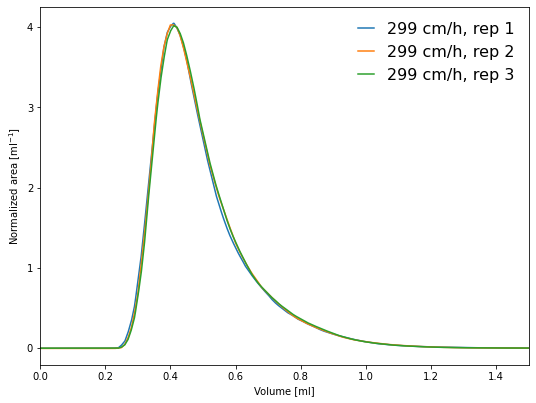

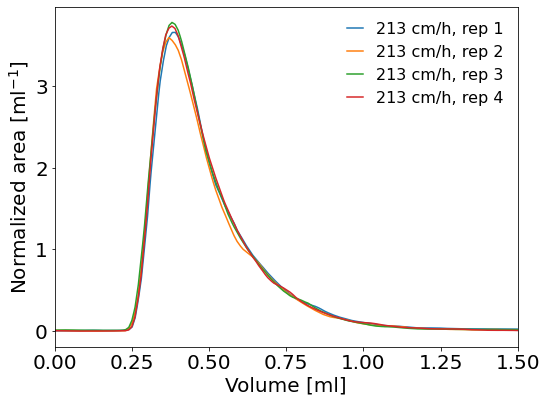

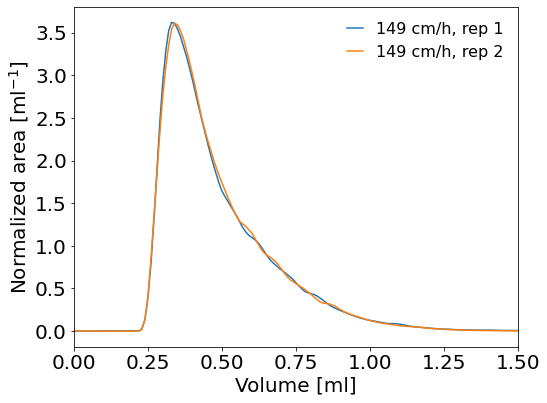

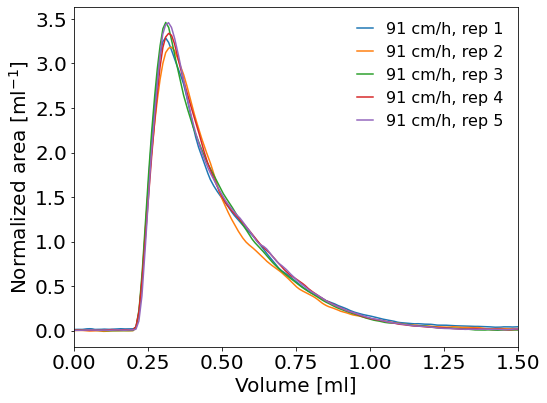

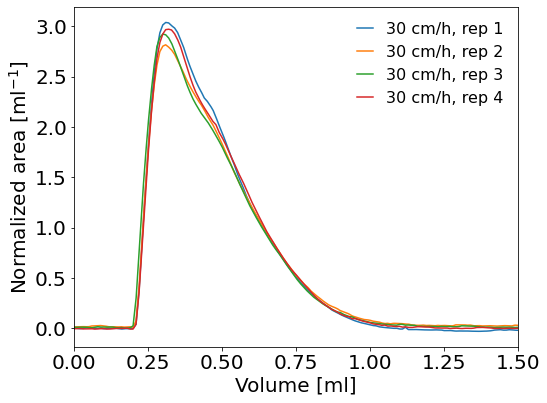

In [7]:
for v in set(velocity_list):
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Volume [ml]')
    ax.set_ylabel('Normalized area [ml$^{-1}$]')

    j = 0
    for i, f in enumerate(files):
        if my_data[f].velocity == v:
            j += 1
            df = my_data[f].df
            letter = f[f.find('.')-1]
            rep_num = rep_dict[letter]

            area = np.trapz(df.UV2_280nm_mAU, df.UV2_280nm_ml)
            label = f"{int(my_data[f].velocity)} cm/h, rep {j}"

            ax.plot(df.UV2_280nm_ml, df.UV2_280nm_mAU/area, label=label)

    ax.set_xlim(0, 1.5)
    ax.legend(loc='best', frameon=False, handlelength=1, prop={'size': 16})
    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/bypass/lysozyme_bypass_{int(v)}_cm_h.png', dpi=300)

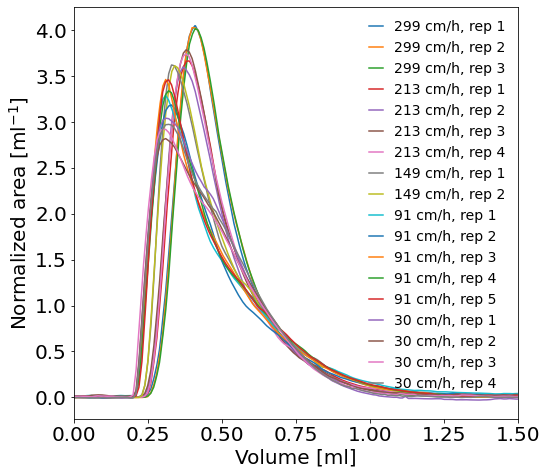

In [8]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 7, forward=True)
ax.set_xlabel('Volume [ml]')
ax.set_ylabel('Normalized area [ml$^{-1}$]')

for v in set(velocity_list):
    j = 0
    for i, f in enumerate(files):
        if v == my_data[f].velocity:
            j += 1
            df = my_data[f].df
            letter = f[f.find('.')-1]
            rep_num = rep_dict[letter]

            area = np.trapz(df.UV2_280nm_mAU, df.UV2_280nm_ml)
            label = f"{int(my_data[f].velocity)} cm/h, rep {j}"

            ax.plot(df.UV2_280nm_ml, df.UV2_280nm_mAU/area, label=label)

ax.set_xlim(0, 1.5)
ax.legend(loc='upper right', frameon=False, handlelength=1, prop={'size': 14})
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/bypass/lysozyme_bypass.png', dpi=300)

In [9]:
moment = []

for i, f in enumerate(files):    
    df = my_data[f].df
    letter = f[f.find('.')-1]
    rep_num = rep_dict[letter]
    label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"
    val = my_help.calc_first_moment(df.UV2_280nm_ml, df.UV2_280nm_mAU)
    
    v_bypass_tube   = np.pi/4.0 * 0.075**2.0 * 27.2
    v_half_inj_loop = 0.05

    val -= (v_bypass_tube + v_half_inj_loop)
    moment.append(val)
    print(label, f'{val:.3f} ml')
    
mu_extra_col = np.array(moment).mean()
sigma = np.array(moment).std(ddof=1)

print('\n', f'Average = {mu_extra_col:.3} ml, STD = {sigma:.3} ml, RSD (%) = {sigma/mu_extra_col*100:.3f}')
print(f'Volume for bypass simulation = {(mu_extra_col + v_bypass_tube):.8f} ml')

299 cm/h, rep 1 0.323 ml
299 cm/h, rep 2 0.306 ml
299 cm/h, rep 3 0.325 ml
149 cm/h, rep 2 0.315 ml
149 cm/h, rep 3 0.304 ml
213 cm/h, rep 1 0.356 ml
91 cm/h, rep 1 0.325 ml
91 cm/h, rep 2 0.370 ml
30 cm/h, rep 1 0.273 ml
213 cm/h, rep 2 0.454 ml
213 cm/h, rep 3 0.318 ml
213 cm/h, rep 4 0.356 ml
91 cm/h, rep 2 0.330 ml
91 cm/h, rep 3 0.318 ml
91 cm/h, rep 4 0.316 ml
30 cm/h, rep 2 0.310 ml
30 cm/h, rep 3 0.298 ml
30 cm/h, rep 4 0.290 ml

 Average = 0.327 ml, STD = 0.0395 ml, RSD (%) = 12.085
Volume for bypass simulation = 0.44718051 ml


In [10]:
extinction_coeff = 37970 # M-1 cm-1

for i, f in enumerate(all_files):    
    df = my_data[f].df
    df['c_280nm_mM'] = df.UV2_280nm_mAU/extinction_coeff
    df['t_280nm_s']  = df.UV2_280nm_ml*60.0/my_data[f].flow

In [11]:
mu_extra_col

0.3270145925824968

### Fitting CSTR fraction

In [12]:
fits = {}

for f in all_files:
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    args = (my_data[f].df, my_data[f].flow, file_path)    

    guess = np.array([0.2])       
    fit = optimize.least_squares(cadet_utils.get_bypass_sim_residual, guess, bounds=[0.0, 1.0], args=args)
    fits[f] = fit
    print(f, '\t', fits[f].x[0])

CH 2021 04 16 lysozyme bypass 1a.xls 	 0.33518987384760796
CH 2021 04 16 lysozyme bypass 1b.xls 	 0.3307514746898679
CH 2021 04 16 lysozyme bypass 1c.xls 	 0.3249732395480075
CH 2021 04 16 lysozyme bypass 2a.xls 	 0.43690429894641597
CH 2021 04 16 lysozyme bypass 2b.xls 	 0.4657680056187885
CH 2021 04 16 lysozyme bypass 2c.xls 	 0.4609390476829786
CH 2021 04 22 lysozyme bypass 3a.xls 	 0.3888809937197286
CH 2021 04 22 lysozyme bypass 4a.xls 	 0.5288400503489861
CH 2021 04 22 lysozyme bypass 4b.xls 	 0.5194531352364773
CH 2021 04 22 lysozyme bypass 5a.xls 	 0.5227172630880884
CH 2021 04 23 lysozyme bypass 3b.xls 	 0.4049186666901275
CH 2021 04 23 lysozyme bypass 3c.xls 	 0.3976358874978366
CH 2021 04 23 lysozyme bypass 3d.xls 	 0.3947235538868276
CH 2021 04 23 lysozyme bypass 4b.xls 	 0.5309673330514949
CH 2021 04 23 lysozyme bypass 4c.xls 	 0.5181119479331517
CH 2021 04 23 lysozyme bypass 4d.xls 	 0.5191773897853549
CH 2021 04 23 lysozyme bypass 5b.xls 	 0.5329161421308191
CH 2021 04 2

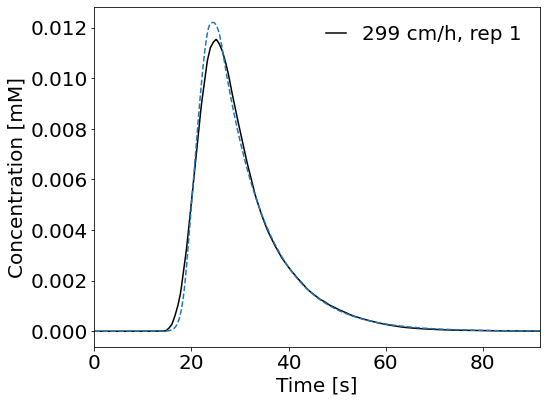

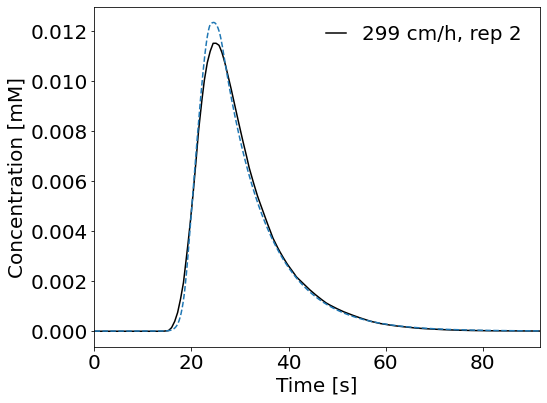

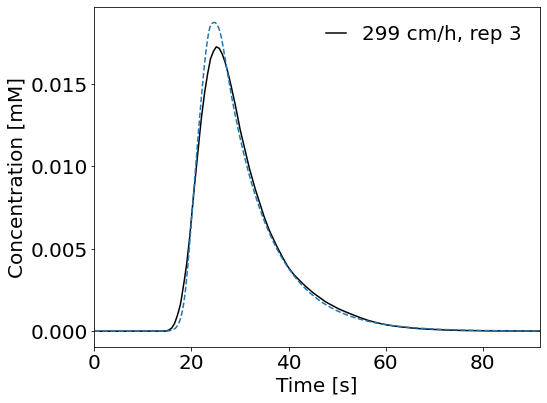

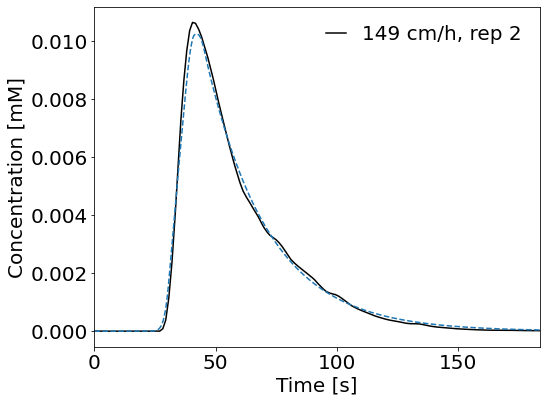

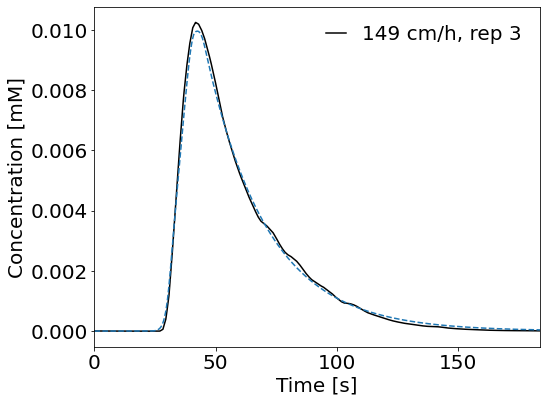

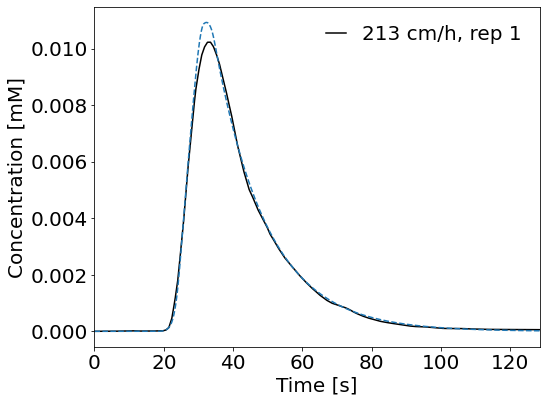

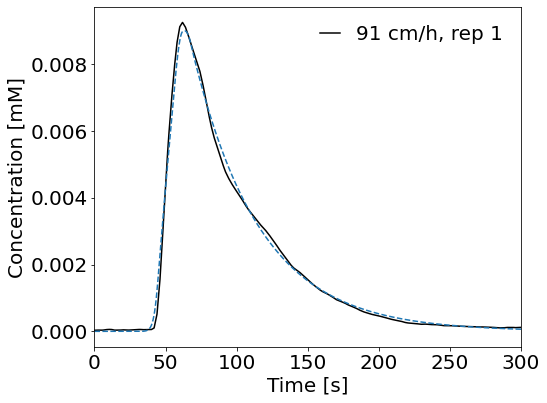

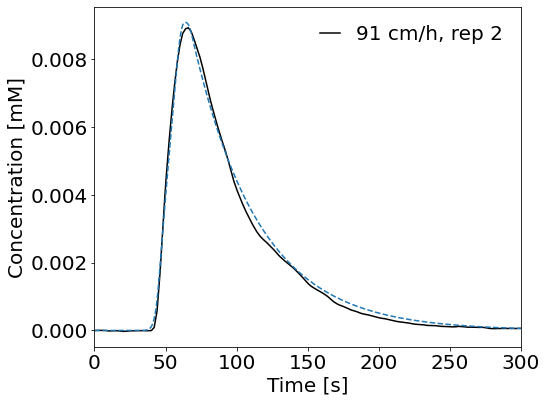

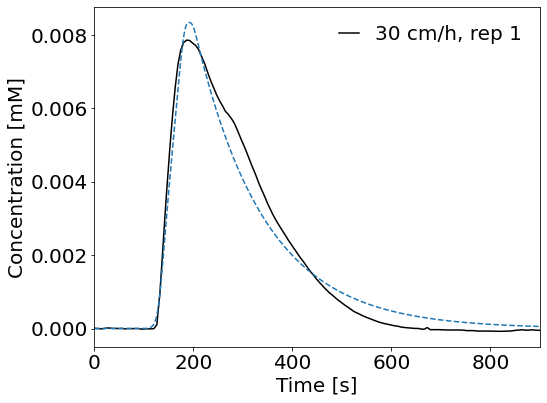

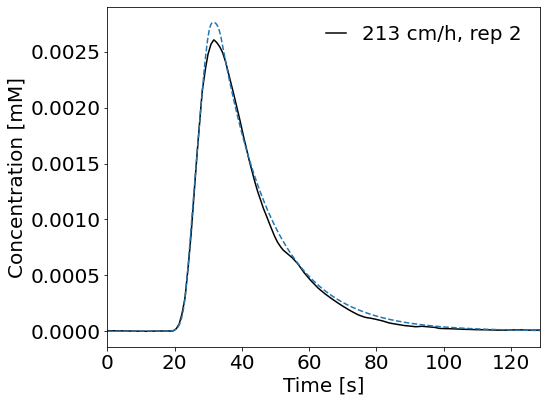

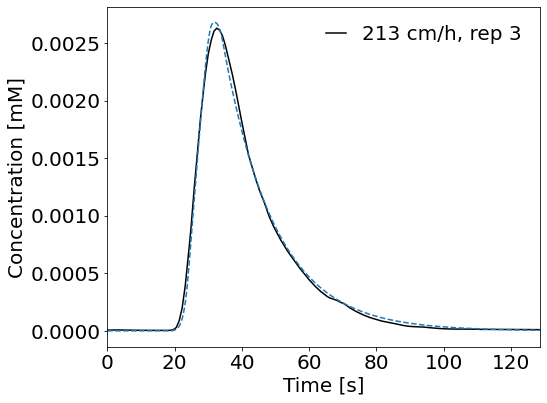

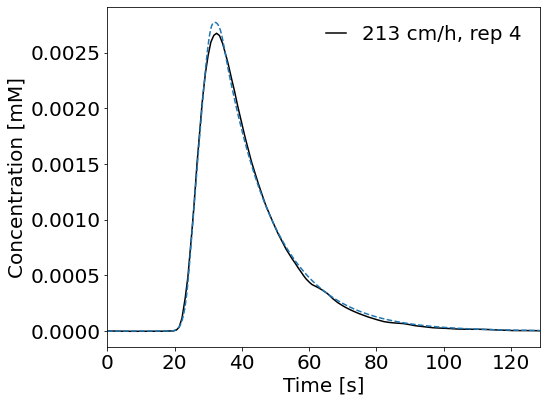

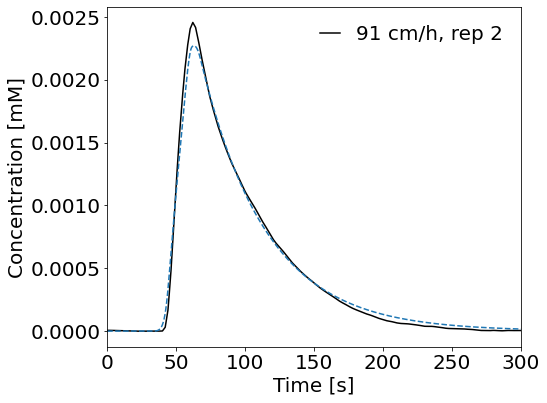

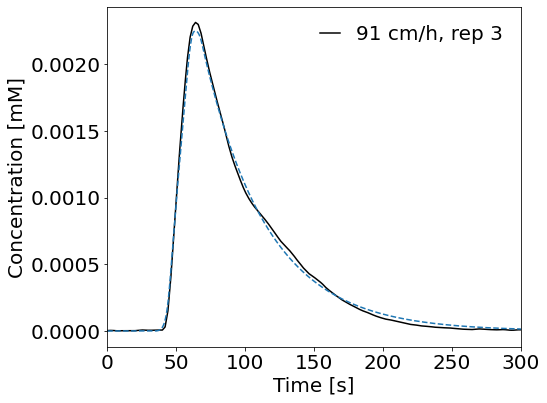

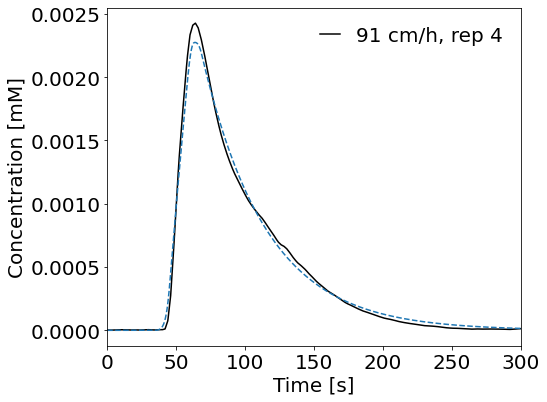

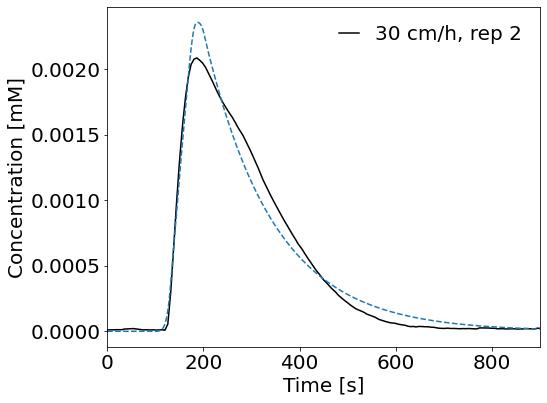

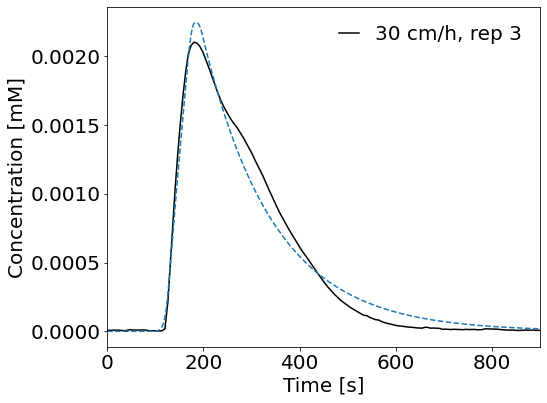

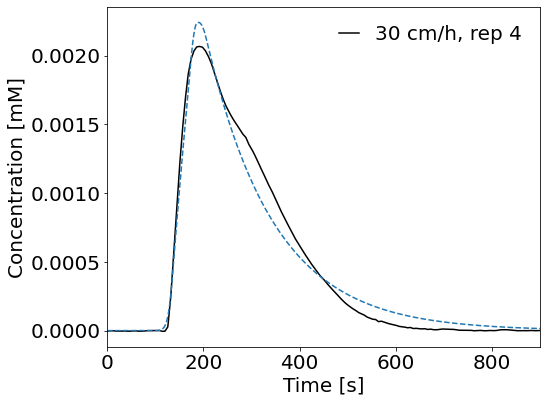

In [13]:
for i, f in enumerate(files):    
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')
    
    df = my_data[f].df
    letter = f[f.find('.')-1]
    rep_num = rep_dict[letter]
    label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"
    ax.plot(df.t_280nm_s, df.c_280nm_mM, label=label, color='black')
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_003.solution_outlet_comp_000
    ax.plot(t, c_out, linestyle='--') #color=plt.gca().lines[-1].get_color()

    ax.set_xlim(0, 1.5*60/my_data[f].flow)
    ax.legend(loc='best', frameon=False, handlelength=1)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()

### Interpolation of fit CSTR fractions with respect to flow rate

In [14]:
flow_vals_list = []
frac_vals_list = []
for f in files:
    flow_vals_list.append(my_data[f].flow)
    frac_vals_list.append(fits[f].x[0])

In [15]:
flow_vals = []
for f in files:
    flow_vals.append(my_data[f].flow)
flow_vals = set(flow_vals)

frac_vals = {}
for flow in flow_vals:
    fracs = []
    for f in files:
        if my_data[f].flow == flow:
            fracs.append(fits[f].x[0])
    frac_vals[flow] = np.array(fracs).mean() 

print(list(frac_vals.keys()), '\n', list(frac_vals.values()))

[0.98, 0.49, 0.1, 0.3, 0.7] 
 [0.3303048626951611, 0.4633535266508836, 0.5318061063506289, 0.5233099712710929, 0.3965397754486301]


In [16]:
frac_cstr_fun = cadet_utils.get_cstr_frac_interp()

new_flows = np.linspace(min(frac_vals.keys()), max(frac_vals.keys()))
new_frac = [cadet_utils.get_cstr_frac(flow) for flow in new_flows]

In [17]:
new_flows

array([0.1       , 0.11795918, 0.13591837, 0.15387755, 0.17183673,
       0.18979592, 0.2077551 , 0.22571429, 0.24367347, 0.26163265,
       0.27959184, 0.29755102, 0.3155102 , 0.33346939, 0.35142857,
       0.36938776, 0.38734694, 0.40530612, 0.42326531, 0.44122449,
       0.45918367, 0.47714286, 0.49510204, 0.51306122, 0.53102041,
       0.54897959, 0.56693878, 0.58489796, 0.60285714, 0.62081633,
       0.63877551, 0.65673469, 0.67469388, 0.69265306, 0.71061224,
       0.72857143, 0.74653061, 0.7644898 , 0.78244898, 0.80040816,
       0.81836735, 0.83632653, 0.85428571, 0.8722449 , 0.89020408,
       0.90816327, 0.92612245, 0.94408163, 0.96204082, 0.98      ])

In [18]:
new_frac

[array(0.53091555),
 array(0.53013333),
 array(0.52935111),
 array(0.52856888),
 array(0.52778666),
 array(0.52700444),
 array(0.52622221),
 array(0.52543999),
 array(0.52465777),
 array(0.52387555),
 array(0.52309332),
 array(0.5223111),
 array(0.5172932),
 array(0.5116065),
 array(0.50591981),
 array(0.50023311),
 array(0.49454642),
 array(0.48885972),
 array(0.48317303),
 array(0.47748633),
 array(0.47179964),
 array(0.46611295),
 array(0.46041715),
 array(0.45469843),
 array(0.4489797),
 array(0.44326098),
 array(0.43754226),
 array(0.43182353),
 array(0.42610481),
 array(0.42038609),
 array(0.41466736),
 array(0.40894864),
 array(0.40322992),
 array(0.39751119),
 array(0.39265027),
 array(0.3883832),
 array(0.38411614),
 array(0.37984907),
 array(0.37558201),
 array(0.37131494),
 array(0.36704788),
 array(0.36278081),
 array(0.35851375),
 array(0.35424668),
 array(0.34997962),
 array(0.34571255),
 array(0.34144549),
 array(0.33717842),
 array(0.33291135),
 array(0.32864429)]

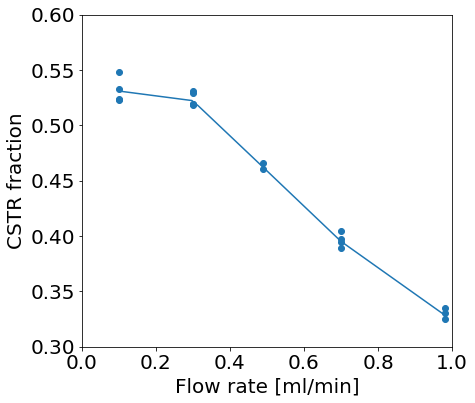

In [19]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(7, 6, forward=True)
ax.set_xlabel('Flow rate [ml/min]')
ax.set_ylabel('CSTR fraction')

ax.scatter(flow_vals_list, frac_vals_list)
ax.plot(new_flows, new_frac)

ax.set_ylim(0.3, 0.6)
ax.set_xlim(0, 1)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/bypass/cstr_frac_values.png', dpi=300, bbox_inches='tight')
fig.savefig('./images/bypass/cstr_frac_values.pdf', bbox_inches='tight')

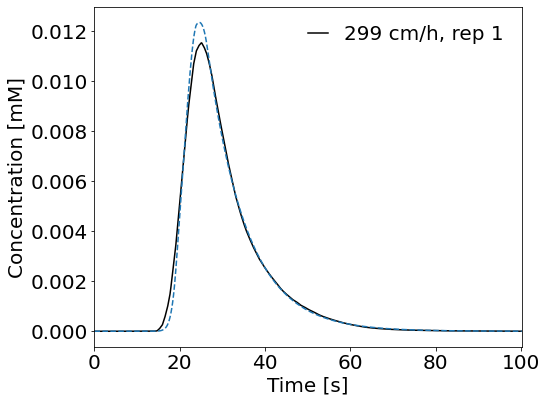

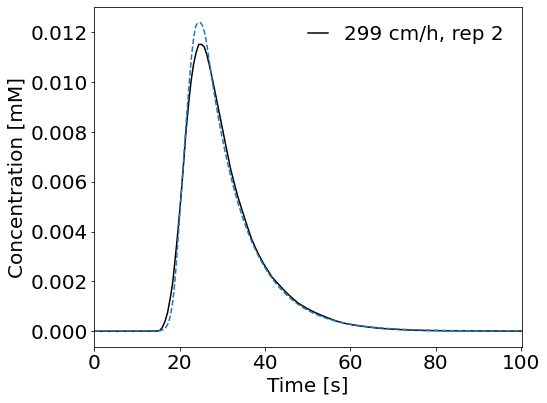

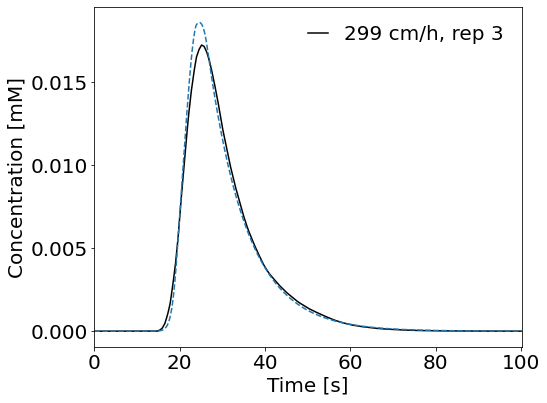

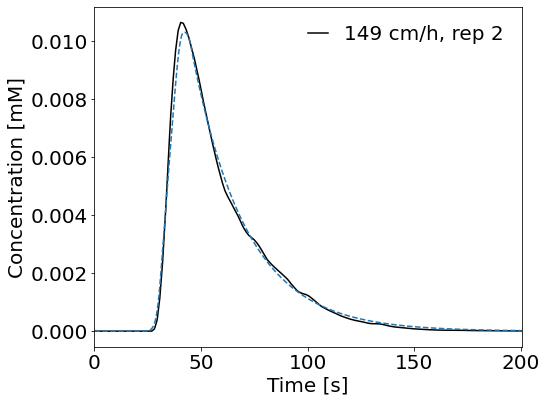

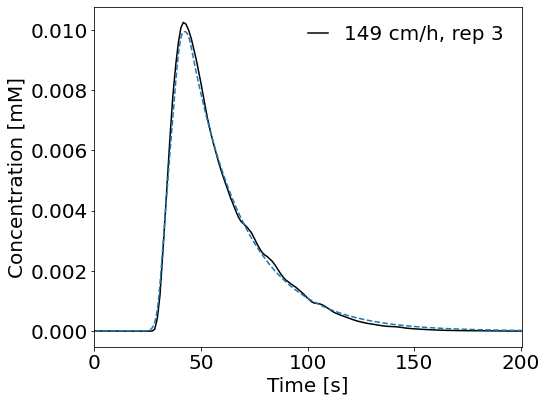

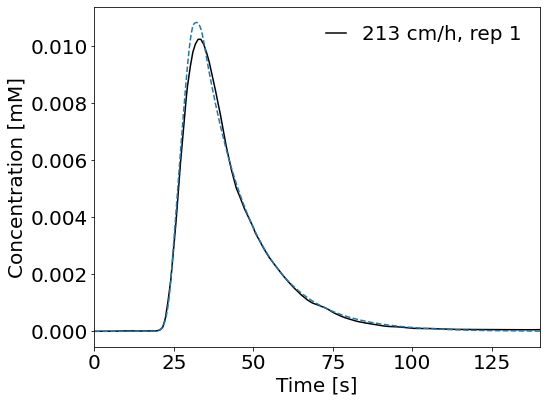

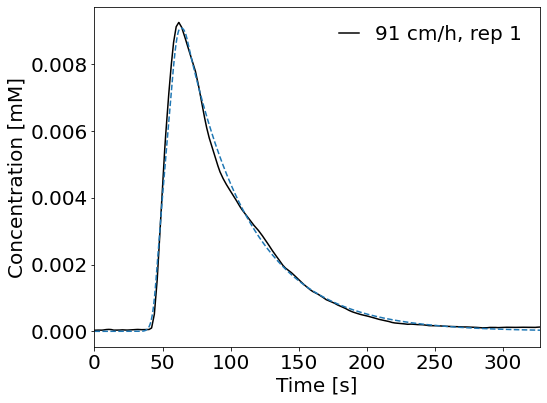

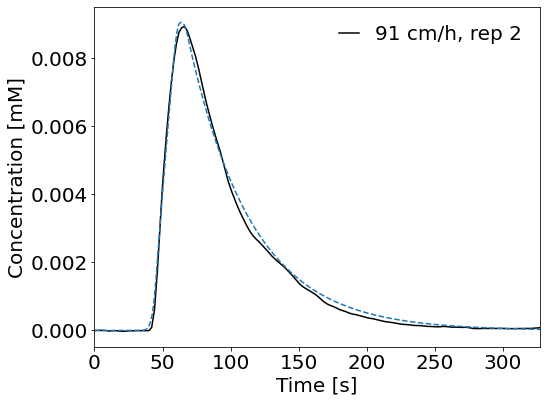

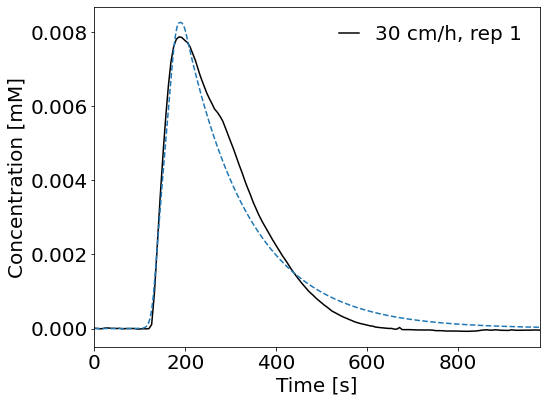

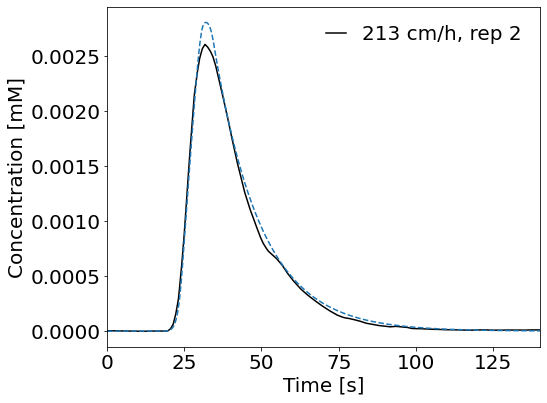

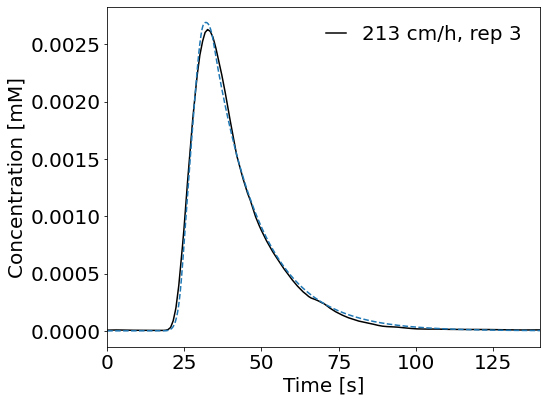

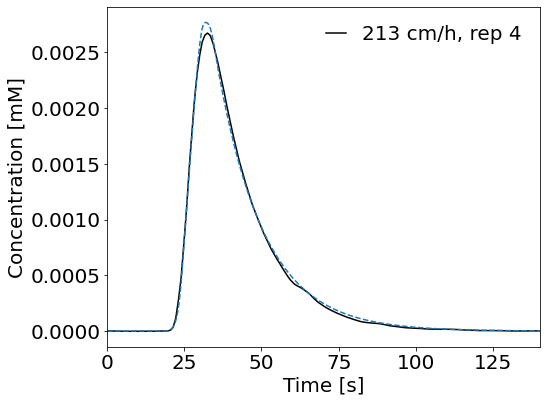

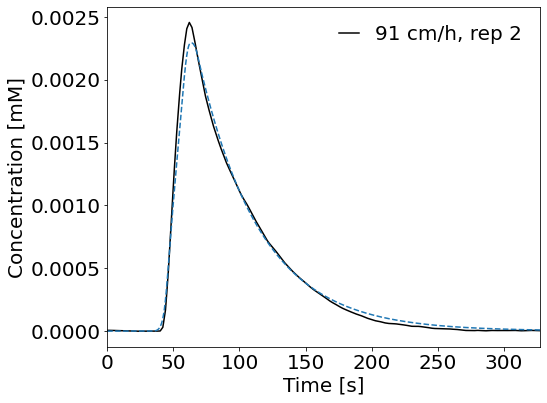

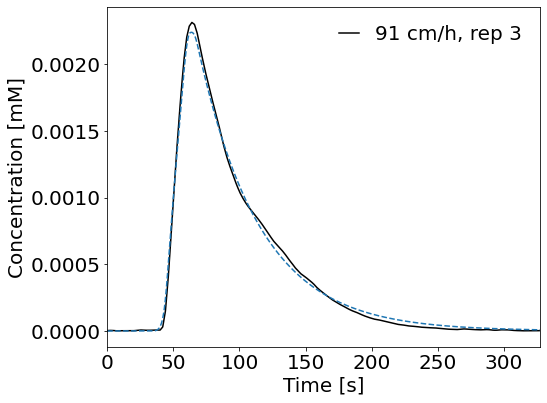

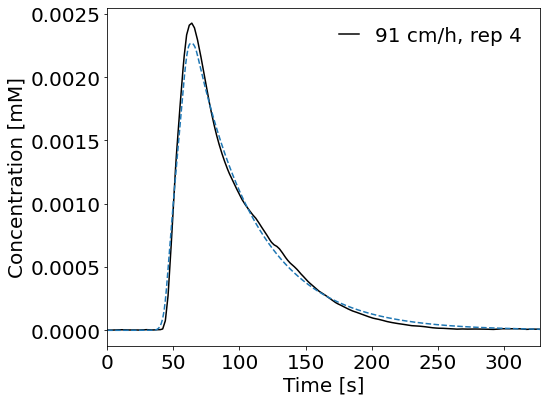

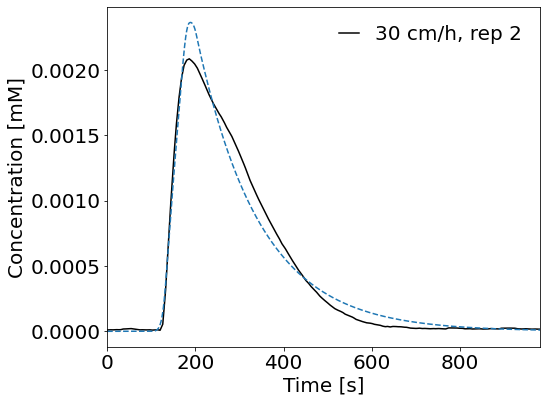

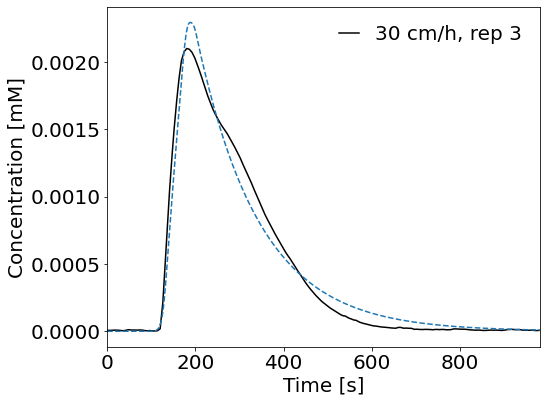

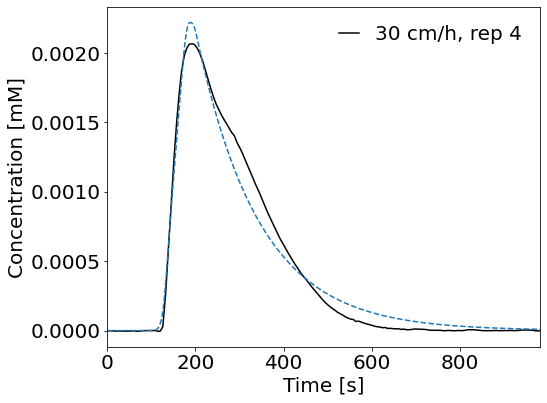

In [20]:
for i, f in enumerate(files):    
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')
    
    df = my_data[f].df
    letter = f[f.find('.')-1]
    rep_num = rep_dict[letter]
    label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"
    ax.plot(df.t_280nm_s, df.c_280nm_mM, label=label, color='black')
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    cstr_frac = cadet_utils.get_cstr_frac(my_data[f].flow)   
    simulation = cadet_utils.set_bypass_sim(cstr_frac, df, my_data[f].flow)
    cadet_utils.run_simulation(simulation, file_path)
    
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_003.solution_outlet_comp_000
    ax.plot(t, c_out, linestyle='--') #color=plt.gca().lines[-1].get_color()

    ax.set_xlim(0, 3e4/my_data[f].velocity) # empirical 
    ax.legend(loc='best', frameon=False, handlelength=1)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/bypass/{file_name}.png', dpi=300)

# Identification of $\epsilon_c$
Blue dextran pulses

In [21]:
directory = './data/data_blue_dextran_on_column/'
files = os.listdir(directory)    
files

['CH 2021 04 16 blue dextran sp seph ff 1a.xls',
 'CH 2021 04 16 blue dextran sp seph ff 1c.xls',
 'CH 2021 04 16 blue dextran sp seph ff 1b.xls']

In [22]:
for f in files:
    my_data[f] = my_plot.data(directory, f)
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=500)

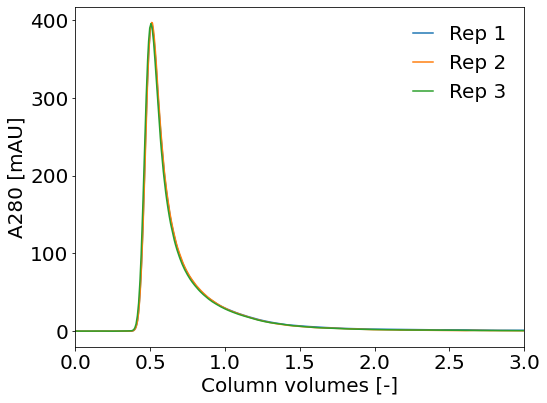

In [23]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

for i, f in enumerate(files):
    df = my_data[f].df
    ax.plot(df.UV2_280nm_cv, df.UV2_280nm_mAU, label=f'Rep {i+1}')

ax.set_xlim(0, 3)
ax.legend(loc='best', frameon=False, handlelength=1)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/blue_dextran.png', dpi=300)

### Using integration

In [24]:
volumes = []

for f in files:
    df = my_data[f].df
    peak_vol = my_help.calc_first_moment(df.UV2_280nm_cv, df.UV2_280nm_mAU)*2.0
    volumes.append(peak_vol)

volumes = np.array(volumes)

v_half_inj_loop = 0.05
mu_dextran_vol = volumes.mean() - v_half_inj_loop
sigma_dextran_vol = volumes.std(ddof=1)
rsd = sigma_dextran_vol/mu_dextran_vol*100.0

print(f'Blue dextran peak volume = {mu_dextran_vol:.3f} ml, RSD = {rsd:.2f}%')

v_due_to_col = mu_dextran_vol - mu_extra_col
eps_c = v_due_to_col/2.0
print(f'Column porosity = {eps_c:.3f}')

Blue dextran peak volume = 1.428 ml, RSD = 5.08%
Column porosity = 0.551


### Using peak location

In [25]:
volumes = []

for f in files:
    df = my_data[f].df
    peak_vol = df.loc[df['UV2_280nm_mAU'] == df.UV2_280nm_mAU.max(), 'UV2_280nm_cv'].iloc[0]*2.0
    volumes.append(peak_vol)

volumes = np.array(volumes)

v_half_inj_loop = 0.0 # 0.05
mu_dextran_vol = volumes.mean() - v_half_inj_loop
sigma_dextran_vol = volumes.std(ddof=1)
rsd = sigma_dextran_vol/mu_dextran_vol*100.0

print(f'Blue dextran peak volume = {mu_dextran_vol:.3f} ml, RSD = {rsd:.2f}%')

v_due_to_col = mu_dextran_vol - mu_extra_col
eps_c = v_due_to_col/2.0
print(f'Column porosity = {eps_c:.3f}')

Blue dextran peak volume = 1.016 ml, RSD = 0.58%
Column porosity = 0.345


### The truth is probably somewhere in between
I'm going to use eps_c from the blue dextran peak location due to dextran heterogeneity

# Identification of $\epsilon_p$, $D_{ax}$, and $D_p$

Lysozyme pulses on column at 100% B

Originally planned to identify $D_{ax} = m Q + b$, but the difference between the fit $D_{ax}$ was small, and went the wrong way with $Q$

**Re-run simulations without changing $D_{ax}$, and see how it affects the $Pe$ number trend**

In [26]:
rep_dict = {"a":1, "b":2, "c":3}

In [27]:
directory = './data/data_lysozyme_on_column/'
files = os.listdir(directory)    
files.sort()
files.remove('other')
files

['CH 2021 04 16 lysozyme sp seph ff 1a.xls',
 'CH 2021 04 16 lysozyme sp seph ff 1b.xls',
 'CH 2021 04 16 lysozyme sp seph ff 1c.xls',
 'CH 2021 04 16 lysozyme sp seph ff 2a.xls',
 'CH 2021 04 16 lysozyme sp seph ff 2b.xls',
 'CH 2021 04 16 lysozyme sp seph ff 2c.xls',
 'CH 2021 04 22 lysozyme sp seph ff 3a.xls',
 'CH 2021 04 22 lysozyme sp seph ff 4a.xls',
 'CH 2021 04 22 lysozyme sp seph ff 5a.xls',
 'CH 2021 04 23 lysozyme sp seph ff 3b.xls',
 'CH 2021 04 23 lysozyme sp seph ff 4b.xls',
 'CH 2021 04 23 lysozyme sp seph ff 5c.xls']

In [28]:
for f in files:
    my_data[f] = my_plot.data(directory, f)
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=500)

In [29]:
velocity_list = []
for f in files:
    velocity_list.append(my_data[f].velocity)

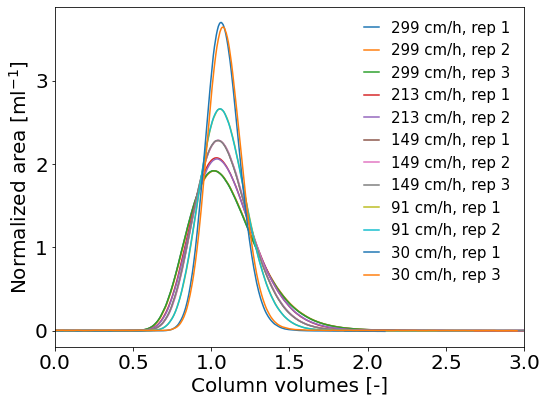

In [30]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('Normalized area [ml$^{-1}$]')

for v in set(velocity_list):
    for i, f in enumerate(files):    
        if v == my_data[f].velocity:
            df = my_data[f].df
            letter = f[f.find('.')-1]
            rep_num = rep_dict[letter]
            label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"

            area = np.trapz(df.UV2_280nm_mAU, df.UV2_280nm_cv)

            ax.plot(df.UV2_280nm_cv, df.UV2_280nm_mAU/area, label=label)

ax.set_xlim(0, 3)
ax.legend(loc='best', frameon=False, handlelength=1, prop={'size':15})
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/pulse/lysozyme_pulse_on_column_100_B.png', dpi=300)

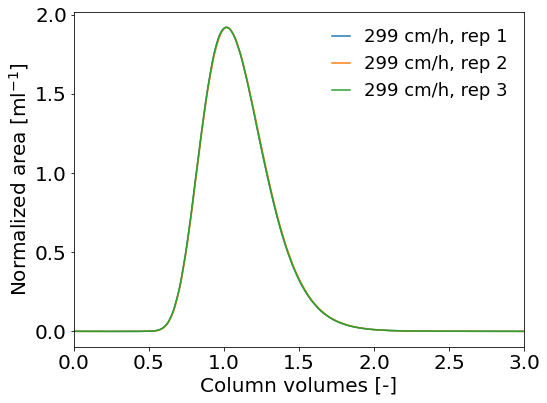

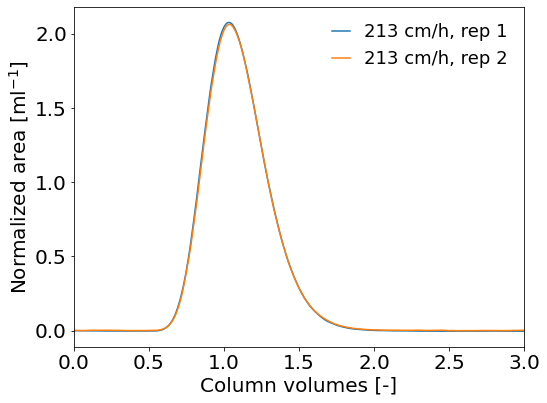

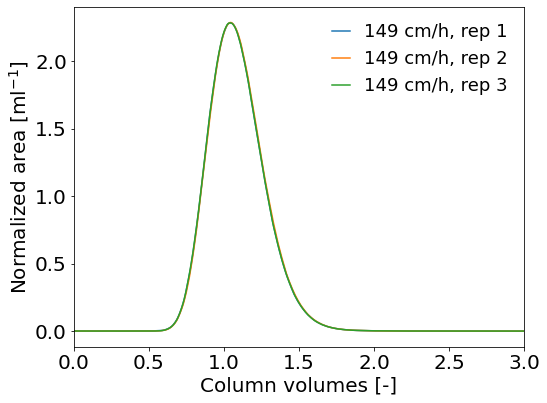

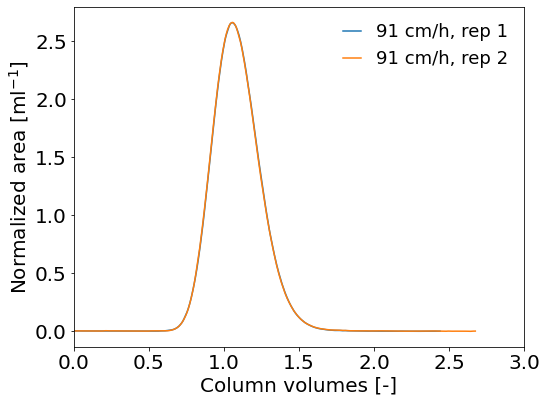

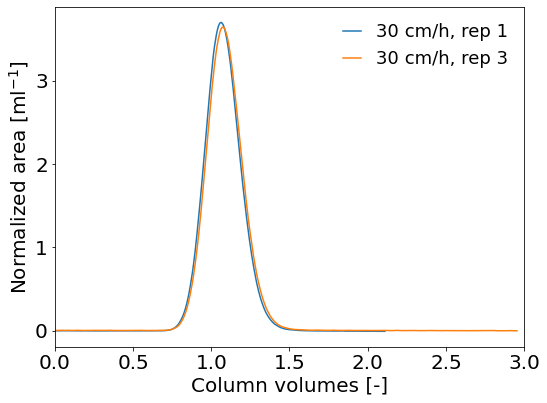

In [31]:
for v in set(velocity_list):
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Column volumes [-]')
    ax.set_ylabel('Normalized area [ml$^{-1}$]')
    
    for i, f in enumerate(files):    
        if v == my_data[f].velocity:
            df = my_data[f].df
            letter = f[f.find('.')-1]
            rep_num = rep_dict[letter]
            label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"

            area = np.trapz(df.UV2_280nm_mAU, df.UV2_280nm_cv)

            ax.plot(df.UV2_280nm_cv, df.UV2_280nm_mAU/area, label=label)

    ax.set_xlim(0, 3)
    ax.legend(loc='best', frameon=False, handlelength=1, prop={'size':18})
    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/pulse/{int(v)}_cm_h.png', dpi=300)

### Identification of $\epsilon_p$

Using integration

In [32]:
volumes = []

for f in files:
    df = my_data[f].df
    vol = my_help.calc_first_moment(df.UV2_280nm_ml, df.UV2_280nm_mAU)
    volumes.append(vol)

volumes = np.array(volumes)

v_half_inj_loop = 0.05
mu_lys_vol = volumes.mean() - v_half_inj_loop
sigma_lys_vol = volumes.std(ddof=1)
rsd = sigma_lys_vol/mu_lys_vol*100.0

print(f'Lysozyme peak volume = {mu_lys_vol:.3f} ml, RSD = {rsd:.2f}%', '\n')

v_eps_t = mu_lys_vol - mu_extra_col
eps_t = v_eps_t/2.0
eps_p = (eps_t - eps_c)/(1.0 - eps_c)

print(f'Total column porosity to lysozyme = {eps_t:.3f}')
print(f'Particle porosity to lysozyme = {eps_p:.3f}')

Lysozyme peak volume = 2.120 ml, RSD = 0.73% 

Total column porosity to lysozyme = 0.897
Particle porosity to lysozyme = 0.842


In [33]:
extinction_coeff = 37970 # M-1 cm-1

for i, f in enumerate(files):    
    df = my_data[f].df
    df['c_280nm_mM'] = df.UV2_280nm_mAU/extinction_coeff
    df['t_280nm_s']  = df.UV2_280nm_ml*60.0/my_data[f].flow

### Parameter estimation

Used/updated during transport parameter estimation (done in the subsequent subsection)

Note: a correction of ~30 ul was added to the simulation setter function, and simulations were re-run, to shift peak moments appropriately.

In [34]:
fit_files = ['CH 2021 04 16 lysozyme sp seph ff 1a.xls',
             'CH 2021 04 16 lysozyme sp seph ff 2a.xls',
             'CH 2021 04 22 lysozyme sp seph ff 3a.xls',
             'CH 2021 04 22 lysozyme sp seph ff 4a.xls',
             'CH 2021 04 22 lysozyme sp seph ff 5a.xls']

In [35]:
def get_combined_residual_pulse(params, Keq, Ds, eps_c, eps_p, my_data):
    residuals = []
    for f in fit_files:
        df = my_data[f].df
        flow = my_data[f].flow
        residual = cadet_utils.get_flowthrough_sim_residual(params, Keq, Ds, eps_p,
                                                            eps_c, df, flow)
        residuals.append(residual)
    
    print(np.array(residuals).sum(), params)
    return np.array(residuals).sum()

**Simultaneous** fit

In [36]:
# bounds = [(1.0e-7, 5.0e-6), (0.5e-6, 3.0e-6), (-3.0e-07, 0.0), (3.5e-11, 4.9e-11)]
# args = (0.0, 0.0, eps_c, eps_p, my_data)
# fit = optimize.differential_evolution(get_combined_residual_pulse,
#                                       bounds, args=args, disp=True, popsize=10, 
#                                       workers=7)
# print(fit)

In [37]:
# guess = [2.71163024e-06,  1.23234119e-06, -1.50564885e-07, 4.32598765e-11]

# bounds = [(-2*guess[0], -2*guess[1], 2*guess[2], 0.5*guess[3]), 
#           (2*guess[0], 2*guess[1], -2*guess[2], 1.5*guess[3])]

# args = (0.0, 0.0, eps_c, eps_p, my_data)

# fit = optimize.least_squares(get_combined_residual_pulse, guess, 
#                              bounds=bounds, args=args)


**Individual fits** - updated when using data for all flow rates

In [38]:
fits_dax = {}

for f in fit_files:
    df   = my_data[f].df
    flow = my_data[f].flow
#     Dp   = 4.32598765e-11
    Dp = 4.3e-11
    
    flow = my_data[f].flow
    Dax_guess = -3.18717719e-06*flow**3.0 + 5.96010627e-06*flow**2.0 -4.02162789e-07*flow + 3.24659041e-08
    
    guess = [Dax_guess]
    
    args = (0.0, 0.0, eps_c, eps_p, df, flow, Dp)
    
    fit = optimize.least_squares(cadet_utils.get_flowthrough_sim_residual, guess, 
                                 args=args)
    fits_dax[f] = fit
    print(f, fits_dax[f].x)

CH 2021 04 16 lysozyme sp seph ff 1a.xls [2.06417505e-06]
CH 2021 04 16 lysozyme sp seph ff 2a.xls [8.34428194e-07]
CH 2021 04 22 lysozyme sp seph ff 3a.xls [1.38530924e-06]
CH 2021 04 22 lysozyme sp seph ff 4a.xls [3.25885235e-07]
CH 2021 04 22 lysozyme sp seph ff 5a.xls [4.77130515e-08]


In [39]:
flows = []
Dax_vals = []

for f in fit_files:
    flows.append(my_data[f].flow)
    Dax_vals.append(fits_dax[f].x[0])
    
Dax_poly = np.polyfit(flows, Dax_vals, 3)
Dax_fun = np.poly1d(Dax_poly)

In [40]:
Dax_poly

array([-2.59169280e-06,  4.73835180e-06, -5.44510238e-08,  3.82792943e-09])

In [41]:
dax_mat = np.array([i for i in zip(flows, Dax_vals)])
dax_mat = dax_mat[np.argsort(dax_mat[:, 0])]
dax_mat

array([[1.00000000e-01, 4.77130515e-08],
       [3.00000000e-01, 3.25885235e-07],
       [4.90000000e-01, 8.34428194e-07],
       [7.00000000e-01, 1.38530924e-06],
       [9.80000000e-01, 2.06417505e-06]])

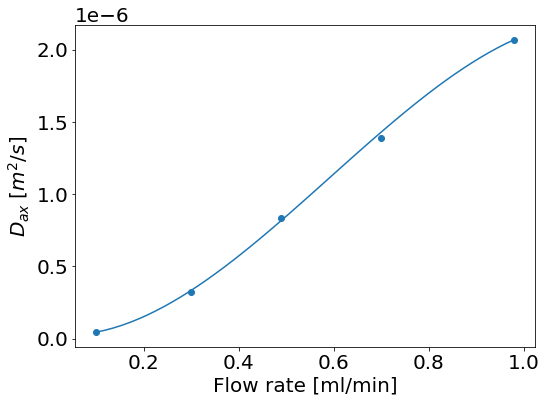

In [42]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Flow rate [ml/min]')
ax.set_ylabel(r'$D_{ax} \; [m^2/s]$')

ax.scatter(flows, Dax_vals)

new_flows = np.linspace(min(flows), max(flows))
# new_Dax = [Dax_fun(flow) for flow in new_flows]
# ax.plot(new_flows, new_Dax)

new_Dax = [cadet_utils.get_Dax(flow) for flow in new_flows]
ax.plot(new_flows, new_Dax)

fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig(f'./images/pulse/Dax_flow_cubic.png', dpi=300)

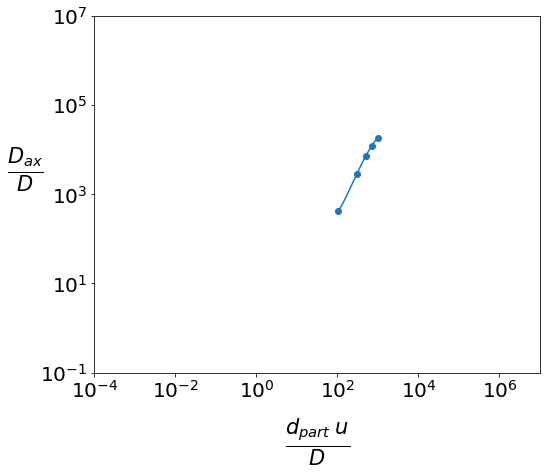

In [43]:
D = 1.15e-10
d_part = 9.0e-5

pe_vals = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in new_flows]
norm_disp = [Dax/D for Dax in new_Dax]

pe_vals_pts = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in flows]
norm_disp_pts = [Dax/D for Dax in Dax_vals]


fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 7, forward=True)
ax.set_xlabel(r'$\frac{d_{part} \; u}{D}$', fontsize=30, labelpad=15)
ax.set_ylabel(r'$\frac{D_{ax}}{D}$', rotation=0, fontsize=30, labelpad=15)

ax.loglog(pe_vals, norm_disp)
ax.loglog(pe_vals_pts, norm_disp_pts, 'o', color=plt.gca().lines[-1].get_color())

# ax.set_xlim(1e1, 1e3)
# ax.set_ylim(1e2, 1e5)
ax.set_xlim(1e-4, 1e7)
ax.set_ylim(1e-1, 1e7)
fig.patch.set_alpha(0.0)
plt.tight_layout()
# fig.savefig(f'./images/pulse/Dax_correlation_scale_comparison.png', dpi=300, transparent=True)
# fig.savefig(f'./images/pulse/Dax_correlation_scale_comparison.pdf', bbox_inches='tight')

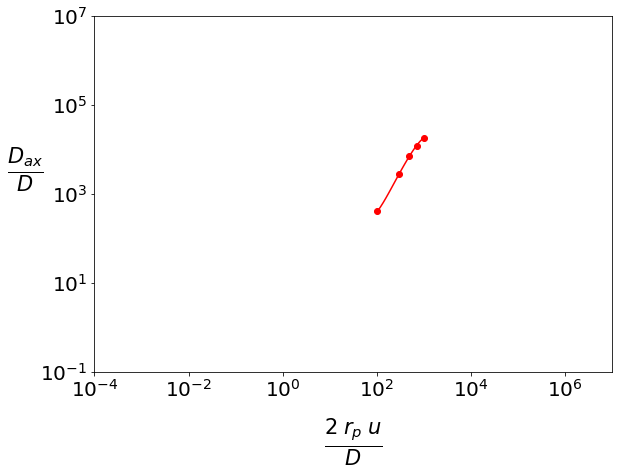

In [48]:
D = 1.15e-10
d_part = 9.0e-5

pe_vals = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in new_flows]
norm_disp = [Dax/D for Dax in new_Dax]

pe_vals_pts = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in flows]
norm_disp_pts = [Dax/D for Dax in Dax_vals]


fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(9, 7, forward=True)
ax.set_xlabel(r'$\frac{2 \; r_p \; u}{D}$', fontsize=30, labelpad=15)
ax.set_ylabel(r'$\frac{D_{ax}}{D}$', rotation=0, fontsize=30, labelpad=15)

ax.loglog(pe_vals, norm_disp, color='red')
ax.loglog(pe_vals_pts, norm_disp_pts, 'o', color=plt.gca().lines[-1].get_color())

# ax.set_xlim(1e1, 1e3)
# ax.set_ylim(1e2, 1e5)
ax.set_xlim(1e-4, 1e7)
ax.set_ylim(1e-1, 1e7)
fig.patch.set_alpha(0.0)
plt.tight_layout()
fig.savefig(f'./images/pulse/Dax_correlation_scale_comparison_radius_label.png', dpi=300, transparent=True)
# fig.savefig(f'./images/pulse/Dax_correlation_scale_comparison_radius_label.pdf', bbox_inches='tight')

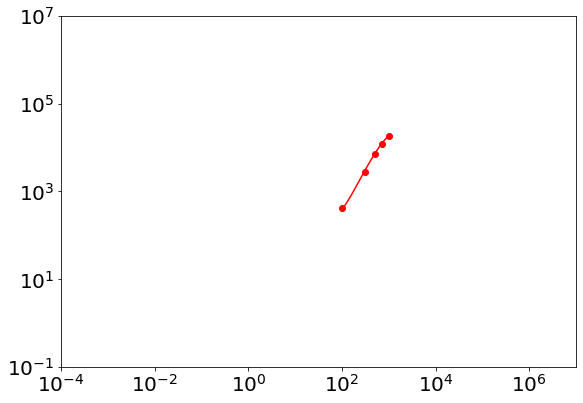

In [50]:
D = 1.15e-10
d_part = 9.0e-5

pe_vals = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in new_flows]
norm_disp = [Dax/D for Dax in new_Dax]

pe_vals_pts = [(d_part/D)*flow/(60*100*np.pi/4 * (0.5**2))/(1.0 - eps_c) for flow in flows]
norm_disp_pts = [Dax/D for Dax in Dax_vals]


fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8.5, 6, forward=True)
# ax.set_xlabel(r'$\frac{2 \; r_p \; u}{D}$', fontsize=30, labelpad=15)
# ax.set_ylabel(r'$\frac{D_{ax}}{D}$', rotation=0, fontsize=30, labelpad=15)

ax.loglog(pe_vals, norm_disp, color='red')
ax.loglog(pe_vals_pts, norm_disp_pts, 'o', color=plt.gca().lines[-1].get_color())

# ax.set_xlim(1e1, 1e3)
# ax.set_ylim(1e2, 1e5)
ax.set_xlim(1e-4, 1e7)
ax.set_ylim(1e-1, 1e7)
fig.patch.set_alpha(0.0)
plt.tight_layout()
fig.savefig(f'./images/pulse/Dax_correlation_scale_comparison_no_label.png', dpi=300, transparent=True)

In [51]:
for f in fit_files:

# for f in files:        
    
    Dax = cadet_utils.get_Dax(my_data[f].flow)
#     Dax = Dax_fun(my_data[f].flow)
#     Dax = fits_dax[f].x
    Dp = 4.3e-11

    simulation = cadet_utils.set_breakthrough_sim_pulse(Keq=0.0, Dax=Dax, Dp=Dp, 
                                                  Ds=0.0, eps_c=eps_c, eps_p=eps_p, 
                                                  data_df=my_data[f].df, 
                                                  flow=my_data[f].flow)

    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name

    cadet_utils.run_simulation(simulation, file_path)

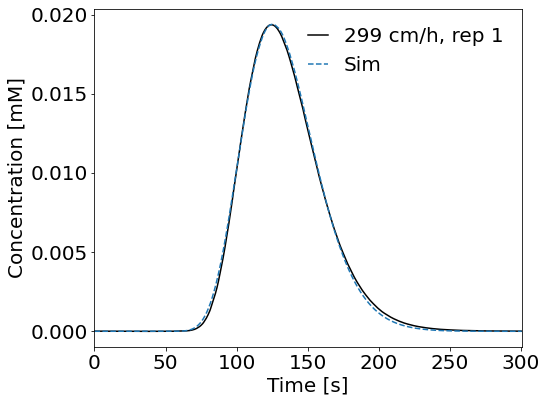

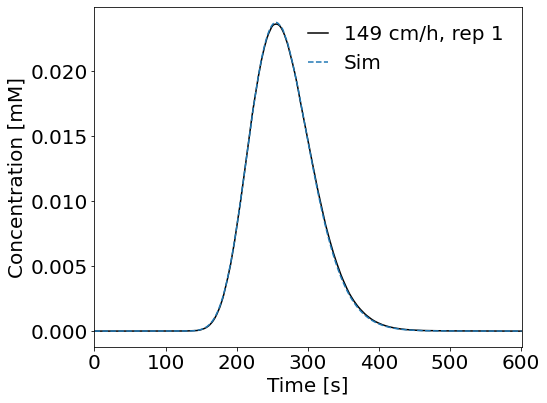

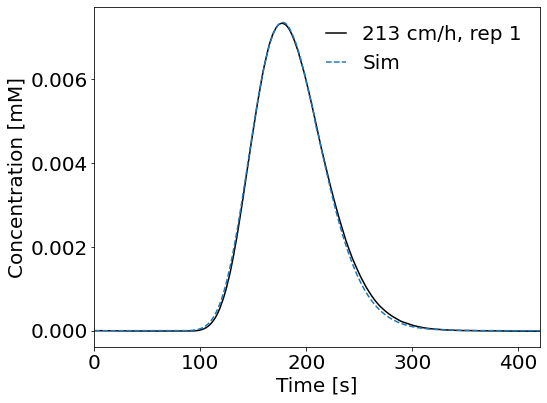

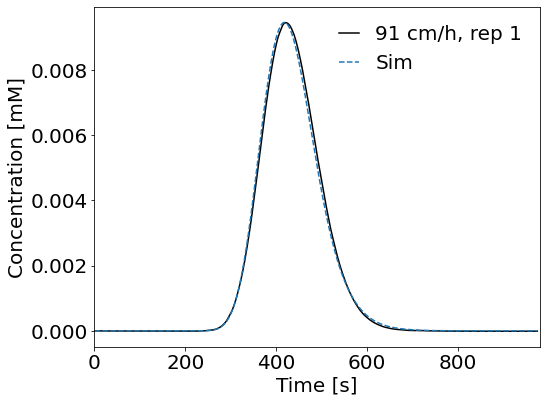

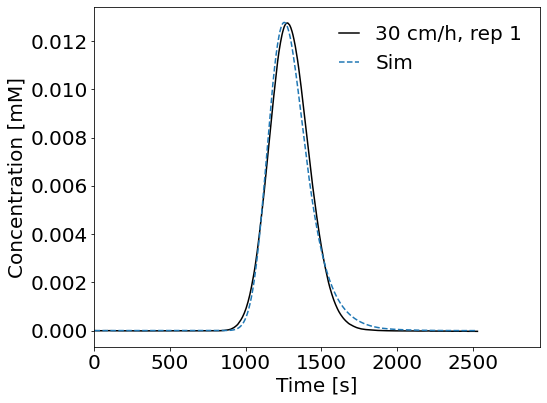

In [52]:
for f in fit_files:

# for f in files:
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')

    df = my_data[f].df
    letter = f[f.find('.')-1]
    rep_num = rep_dict[letter]
    label = f"{int(my_data[f].velocity)} cm/h, rep {rep_num}"
    ax.plot(df.t_280nm_s, df.c_280nm_mM, label=label, color='black')
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t, c_out, linestyle='--', label='Sim') #color=plt.gca().lines[-1].get_color()

    ax.set_xlim(0, 9e4/my_data[f].velocity)
    ax.legend(loc='best', frameon=False, handlelength=1)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/pulse/{file_name}.png', dpi=300)

In [53]:
vol_correction_ml = []

for f in files:
    df = my_data[f].df
    moment_data = my_help.calc_first_moment(df.t_280nm_s, df.c_280nm_mM)
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    moment_sim = my_help.calc_first_moment(t, c_out)

    vol_correction_ml.append((moment_data - moment_sim)*my_data[f].flow/60.0)
    
for (f, corr) in zip(files, vol_correction_ml):
    print(f'{my_data[f].flow:.2f} ml/min, \t  {corr:.5f} ml')

0.98 ml/min, 	  0.01440 ml
0.98 ml/min, 	  0.01084 ml
0.98 ml/min, 	  0.01080 ml
0.49 ml/min, 	  -0.01471 ml
0.49 ml/min, 	  -0.02260 ml
0.49 ml/min, 	  -0.01676 ml
0.70 ml/min, 	  -0.00040 ml
0.30 ml/min, 	  0.00168 ml
0.10 ml/min, 	  -0.01854 ml
0.70 ml/min, 	  0.02908 ml
0.30 ml/min, 	  -0.00043 ml
0.10 ml/min, 	  0.00457 ml


In [54]:
print(np.array(vol_correction_ml).mean())

-0.00017299860891583748


# Lysozyme breakthrough
On column at 100% B

In [55]:
directory = './data/data_lysozyme_breakthrough/'
files = os.listdir(directory)    
files.sort()
files.remove('other')
files

['CH 2021 04 22 sp seph ff flowthrough 100 B 1.xls',
 'CH 2021 04 22 sp seph ff flowthrough 100 B 2.xls',
 'CH 2021 04 22 sp seph ff flowthrough 100 B 3.xls',
 'CH 2021 04 22 sp seph ff flowthrough 100 B 4.xls',
 'CH 2021 04 22 sp seph ff flowthrough 100 B 5.xls']

In [56]:
for f in files:
    my_data[f] = my_plot.data(directory, f)
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=100)

In [57]:
velocity_list = []

for f in files:
    velocity_list.append(my_data[f].velocity)
    
velocity_list.sort()

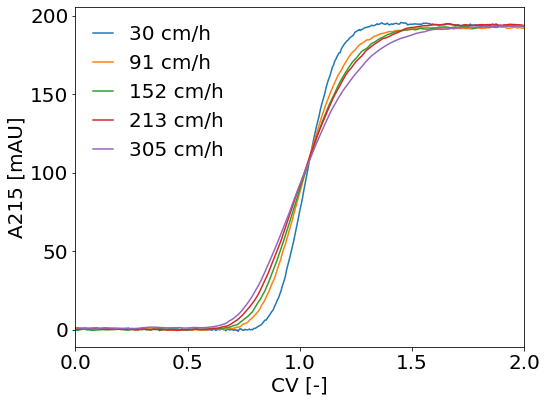

In [58]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV [-]')
ax.set_ylabel('A215 [mAU]')

for v in velocity_list:
    for i, f in enumerate(files):
        if v == my_data[f].velocity:
            df = my_data[f].df    
            ax.plot(df.UV1_215nm_cv, df.UV1_215nm_mAU, label=f'{int(v)} cm/h')

ax.set_xlim(0, 2)
ax.legend(loc='best', frameon=False, handlelength=1)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough_100_B/lysozyme_breakthrough_100_B.png', dpi=300)

In [59]:
max_vals = []

for f in files:
    df = my_data[f].df
    max_vals.append(df.UV1_215nm_mAU.max())
    
mean_max_val = np.array(max_vals).mean()
std_val = np.array(max_vals).std(ddof=1)
rsd = std_val/mean_max_val*100

print(f'Mean of max values = {mean_max_val:.2f}, RSD = {rsd:.2f}%')

Mean of max values = 194.16, RSD = 0.53%


In [60]:
epsilon = 344815 # 214 nm, https://bestsel.elte.hu/extcoeff.php

c_load = (mean_max_val)/epsilon
print(f'Load c = {c_load} mM')

Load c = 0.0005630735321839246 mM


In [61]:
for i, f in enumerate(files):    
    df = my_data[f].df
    df['c_215nm_mM'] = df.UV1_215nm_mAU/epsilon
    df['t_215nm_s']  = df.UV1_215nm_ml*60.0/my_data[f].flow

In [62]:
Keq = 0.0
Ds  = 0.0
Dp  = 4.3e-11

for f in files:
    flow = my_data[f].flow
    Dax = cadet_utils.get_Dax(flow)
    
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                                                  Dp=Dp, Ds=Ds, eps_c=eps_c, 
                                                  eps_p=eps_p, data_df=my_data[f].df,
                                                  flow=flow)

    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name

    cadet_utils.run_simulation(simulation, file_path)

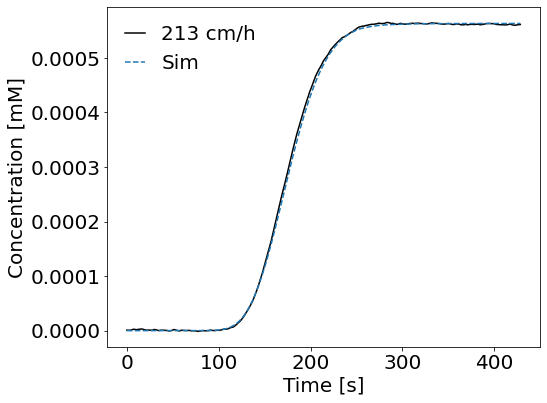

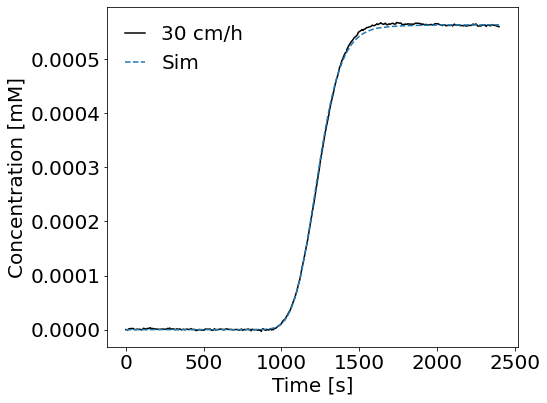

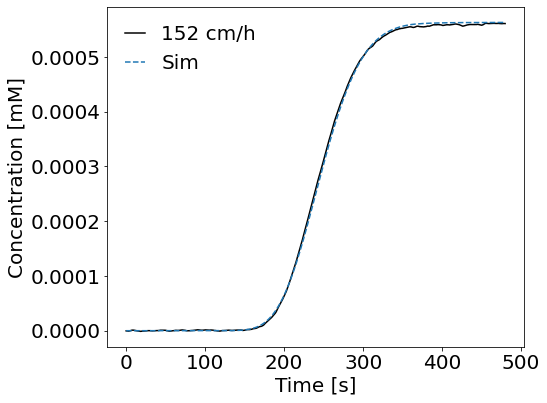

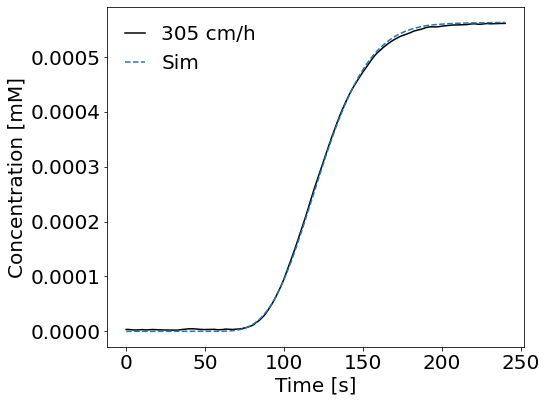

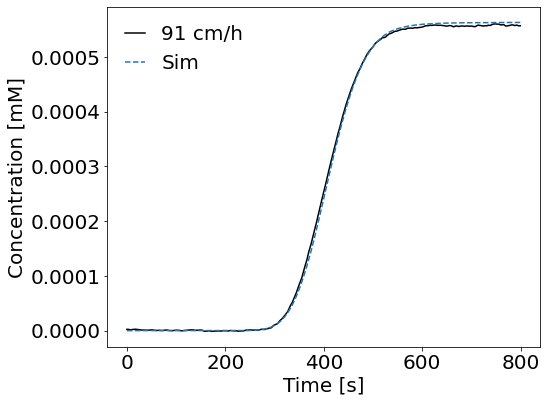

In [63]:
for f in files:
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')

    df = my_data[f].df
    label = f'{int(my_data[f].velocity)} cm/h'
    ax.plot(df.t_215nm_s, df.c_215nm_mM, label=label, color='black')
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t, c_out, linestyle='--', label='Sim') #color=plt.gca().lines[-1].get_color()

    ax.legend(loc='best', frameon=False, handlelength=1)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/breakthrough_100_B/{int(my_data[f].velocity)}_cm_h.png', dpi=300)

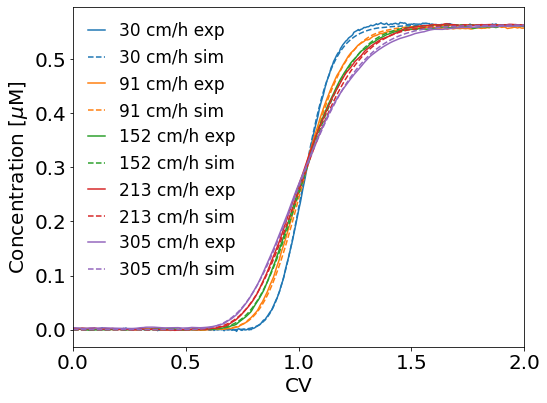

In [64]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV')
ax.set_ylabel(r'Concentration [$\mu$M]')

for v in velocity_list:
    for i, f in enumerate(files):
        if v == my_data[f].velocity:    
            df = my_data[f].df
            label = f'{int(my_data[f].velocity)} cm/h'
            ax.plot(df.UV1_215nm_cv, df.c_215nm_mM*1e3, label=label+' exp')

            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            t      = simulation.root.output.solution.solution_times
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            ax.plot(t*my_data[f].flow/120, c_out*1e3, linestyle='--', color=plt.gca().lines[-1].get_color(),
                   label=label+' sim')

ax.legend(loc='best', frameon=False, handlelength=1, fontsize=17)
ax.set_xlim(0, 2.0)

fig.patch.set_alpha(1.0)
plt.tight_layout()
            
# fig.savefig(f'./images/breakthrough_100_B/all_labeled.png', dpi=300)

# fig.savefig(f'./images/manuscript_images/breakthrough_100_B.png', dpi=150)
# fig.savefig(f'./images/manuscript_images/breakthrough_100_B.pdf')

In [65]:
velocity_list_save = velocity_list
files_save = files
my_data_save = my_data

In [66]:
max_vals = []
for v in velocity_list:
    for i, f in enumerate(files):
        if v == my_data[f].velocity:    
            df = my_data[f].df
            max_vals.append(max(df.c_215nm_mM*1e3))
            
            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            max_vals.append(max(c_out*1e3))
            
max_val = max(max_vals)

In [69]:
d_particle = 9.0e-5 # m

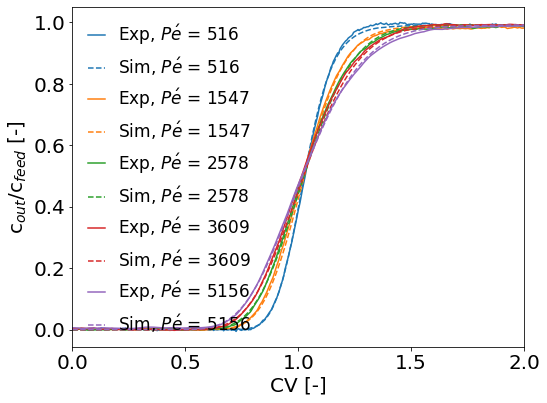

In [70]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for v in velocity_list:
    for i, f in enumerate(files):
        if v == my_data[f].velocity:    
            df = my_data[f].df
            pe_val = d_particle * my_data[f].velocity / (eps_c * 100 * 3600 * Dp)
            label = fr'$P\'{{e}}$ = {pe_val:.0f}'
            ax.plot(df.UV1_215nm_cv, df.c_215nm_mM*1e3/max_val, label='Exp, ' + label)

            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            t      = simulation.root.output.solution.solution_times
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            ax.plot(t*my_data[f].flow/120, c_out*1e3/max_val, linestyle='--', color=plt.gca().lines[-1].get_color(),
                   label='Sim, ' + label)

ax.legend(loc='upper left', frameon=False, handlelength=1, fontsize=17)
ax.set_xlim(0, 2.0)

fig.patch.set_alpha(1.0)
plt.tight_layout()

# fig.savefig(f'./images/breakthrough_100_B/all_labeled_reformatted.png', dpi=300)

# Estimation of $K_{eq}$, $D_s$, and validation of $D_{ax}$, $D_p$ estimates

Lyszome dilute breakthrough, 20% B, rep 2

In [71]:
directory = './data/randomized_data_20_B_rep_2/'
files = os.listdir(directory)
files.sort()
files

['CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2001.xls',
 'CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2002.xls',
 'CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2003.xls',
 'CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2004.xls',
 'CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2005.xls']

In [72]:
my_data = {}
velocities = []

for i, f in enumerate(files):
    my_data[f] = my_plot.data(directory, f)

    if i == 0 or i == 2: # determined by looking at data files
        flow_ind = 4000
    elif i == 3:
        flow_ind = 5000
    else:
        flow_ind = 3000    
    
    my_data[f].add_velocity_and_cv(v_col=2.0, d_col=0.5, flow_ind=flow_ind)
    velocities.append(my_data[f].velocity)

velocities.sort()

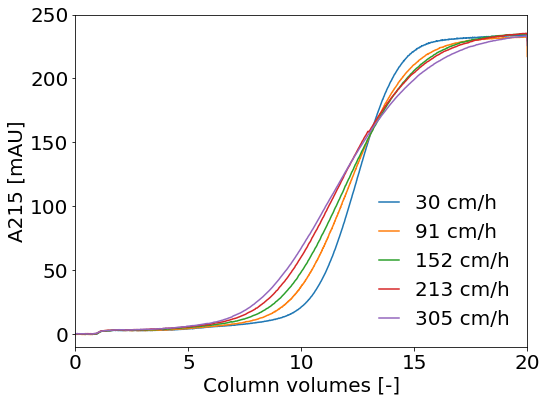

In [73]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A215 [mAU]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = my_data[f].df
            inject_cv = [x for x in df['Inject_cv'] if str(x) != 'nan']
            ax.plot(df['UV1_215nm_cv'] - inject_cv[-1], df['UV1_215nm_mAU'], label=f'{int(my_data[f].velocity)} cm/h')

ax.legend(loc='lower right', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(-10, 250)

fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough/20_B_randomized_study_rep_2.png', dpi=300)

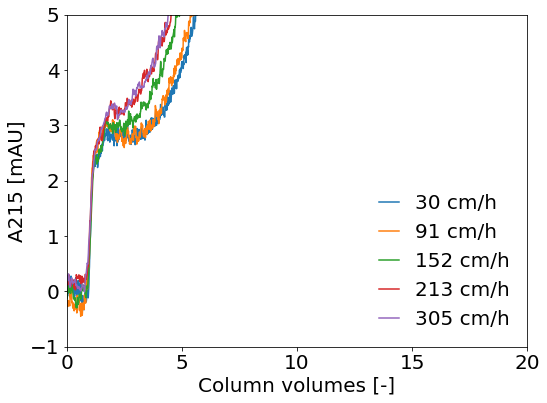

In [74]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A215 [mAU]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = my_data[f].df
            inject_cv = [x for x in df['Inject_cv'] if str(x) != 'nan']
            ax.plot(df['UV1_215nm_cv'] - inject_cv[-1], df['UV1_215nm_mAU'], label=f'{int(my_data[f].velocity)} cm/h')

ax.legend(loc='lower right', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(-1, 5)

fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough/20_B_randomized_study_rep_2.png', dpi=300)

In [75]:
max_vals = []

for f in files:
    df = my_data[f].df
    inject_cv = [x for x in df['Inject_cv'] if str(x) != 'nan']
    df_load = df[(0.0 < df['UV1_215nm_cv'] - inject_cv[-1]) &\
                 (df['UV1_215nm_cv'] - inject_cv[-1] < 20.0)]
    max_vals.append(df_load.UV1_215nm_mAU.max())
    
mean_max_val = np.array(max_vals).mean()
std_val = np.array(max_vals).std(ddof=1)
rsd = std_val/mean_max_val*100

print(f'Mean of max values = {mean_max_val:.2f}, RSD = {rsd:.2f}%')

Mean of max values = 234.02, RSD = 0.49%


In [76]:
epsilon = 344815 # 214 nm, https://bestsel.elte.hu/extcoeff.php
impurity_correction = 2.7

c_load = (mean_max_val - impurity_correction)/epsilon
print(f'Load c = {c_load} mM')

Load c = 0.0006708536461580847 mM


In [77]:
data_break = {}

for f in files:
    df = my_data[f].df
    inject_cv = [x for x in df['Inject_cv'] if str(x) != 'nan']
    df_load = df[(0.0 < df['UV1_215nm_cv'] - inject_cv[-1]) &\
                 (df['UV1_215nm_cv'] - inject_cv[-1] < 20.0)].copy()
    df_load.reset_index(inplace=True, drop=True)
    
    df_load['c_215nm_mM'] = (df_load.UV1_215nm_mAU - impurity_correction)/epsilon
    df_load['t_215nm_s'] = (df_load['UV1_215nm_ml'] - df_load.at[0, 'UV1_215nm_ml'])*60.0/my_data[f].flow
    
    data_break[f] = df_load

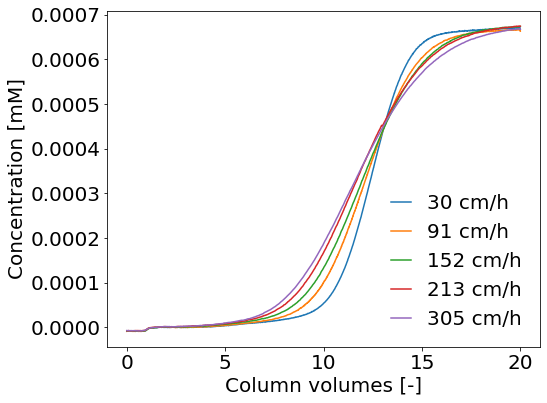

In [78]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('Concentration [mM]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            label = f'{int(my_data[f].velocity)} cm/h'
            ax.plot(df.t_215nm_s*my_data[f].flow/120.0, df.c_215nm_mM, label=label)
    

ax.legend(loc='lower right', frameon=False, handlelength=1)
# ax.set_xlim(0, 20)
# ax.set_ylim(-10, 250)

fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough/rep_2_20_B_just_data.png', dpi=300)

In [79]:
# Dp, eps_p, eps_c
Dp, eps_p, eps_c = (4.3e-11, 0.8421529231673788, 0.34456262415678807)

In [80]:
# Keq = 109.13425100850195 
# Ds = 1.1563530583011522e-12

Keq = 1.08620741e+02
Ds = 1.49247190e-12

for f in files:
    flow = my_data[f].flow
    Dax = cadet_utils.get_Dax(flow)
    
#     Keq = fits[f].x[0]
#     Ds  = fits[f].x[1]
    
    simulation = cadet_utils.set_breakthrough_sim(Keq=Keq, c_load=c_load, Dax=Dax, 
                                                  Dp=Dp, Ds=Ds, eps_c=eps_c, 
                                                  eps_p=eps_p, data_df=data_break[f],
                                                  flow=flow)

    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name

    cadet_utils.run_simulation(simulation, file_path)

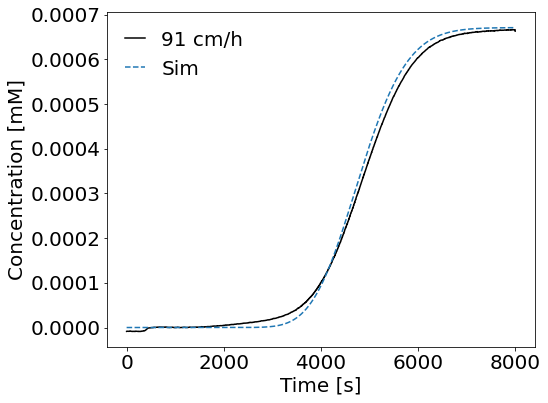

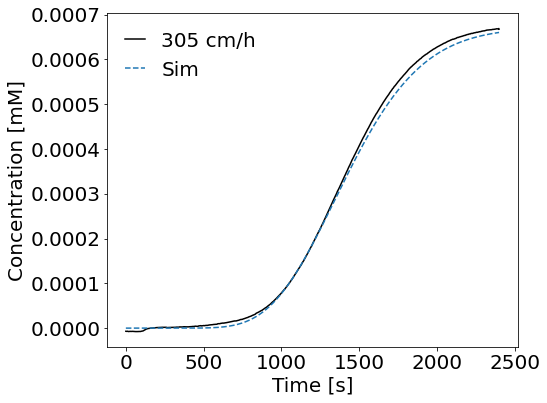

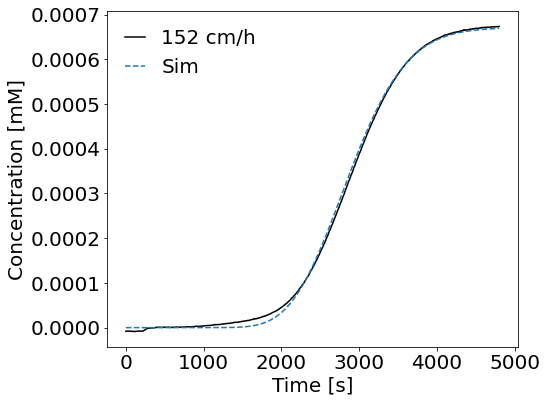

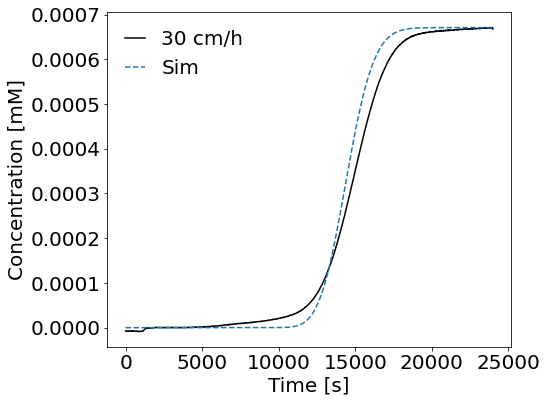

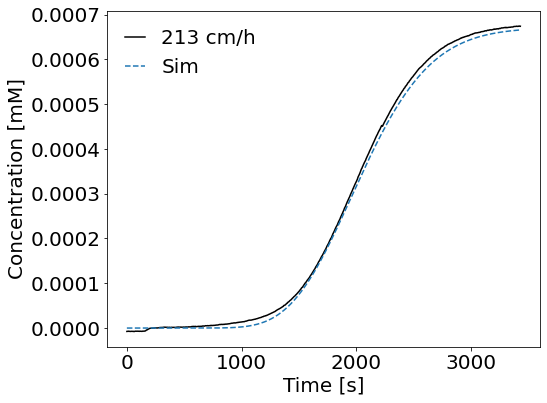

In [81]:
for f in files:
    fig, ax = plt.subplots()
    font    = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 6, forward=True)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')

    df = data_break[f]
    label = f'{int(my_data[f].velocity)} cm/h'
    ax.plot(df.t_215nm_s, df.c_215nm_mM, label=label, color='black')
    
    file_name = f[:f.find('.')] + '.h5'
    file_path = './hdf5_simulation_files/' + file_name
    simulation = Cadet()
    simulation.filename = file_path
    simulation.load()
    t      = simulation.root.output.solution.solution_times
    c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
    ax.plot(t, c_out, linestyle='--', label='Sim') #color=plt.gca().lines[-1].get_color()
    
#     ax.text()
    ax.legend(loc='best', frameon=False, handlelength=1)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()
#     fig.savefig(f'./images/breakthrough/average_of_individual_{file_name}.png', dpi=300)

In [82]:
velocities

[30.557749073643905,
 91.67324722093171,
 152.78874536821954,
 213.90424351550732,
 305.5774907364391]

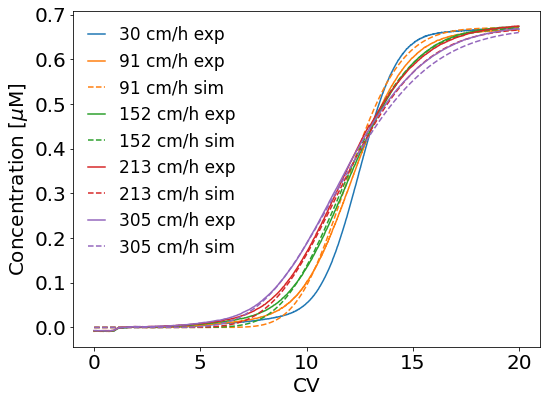

In [83]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV')
ax.set_ylabel(r'Concentration [$\mu$M]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            label = f'{int(my_data[f].velocity)} cm/h'
            flow = my_data[f].flow
            ax.plot(df.t_215nm_s*flow/(2.0*60.0), df.c_215nm_mM*1e3, label=label + ' exp')
    
            if v > 31:
                file_name = f[:f.find('.')] + '.h5'
                file_path = './hdf5_simulation_files/' + file_name
                simulation = Cadet()
                simulation.filename = file_path
                simulation.load()
                t      = simulation.root.output.solution.solution_times
                c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
                ax.plot(t*flow/(2.0*60.0), c_out*1e3, linestyle='--', color=plt.gca().lines[-1].get_color(), label=label + ' sim') 

ax.legend(loc='best', frameon=False, handlelength=1, fontsize=17)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough/global_without_30.png', dpi=300)

# fig.savefig('./images/manuscript_images/global_without_30.png', dpi=150)
# fig.savefig('./images/manuscript_images/global_without_30.pdf')

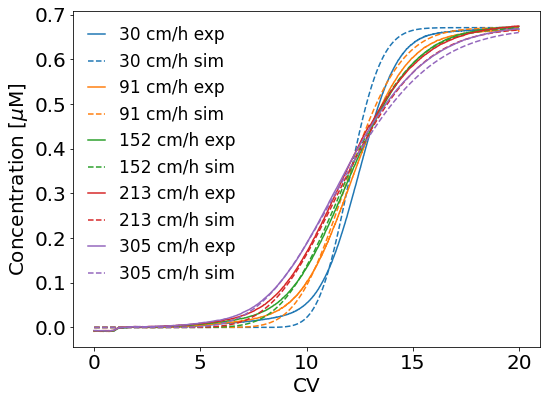

In [84]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV')
ax.set_ylabel(r'Concentration [$\mu$M]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            label = f'{int(my_data[f].velocity)} cm/h'
            flow = my_data[f].flow
            ax.plot(df.t_215nm_s*flow/(2.0*60.0), df.c_215nm_mM*1e3, label=label + ' exp')
    
            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            t      = simulation.root.output.solution.solution_times
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            ax.plot(t*flow/(2.0*60.0), c_out*1e3, linestyle='--', color=plt.gca().lines[-1].get_color(), label=label + ' sim') 

ax.legend(loc='best', frameon=False, handlelength=1, fontsize=17)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/breakthrough/global_without_30.png', dpi=300)

# fig.savefig('./images/manuscript_images/global_with_30.png', dpi=150)
# fig.savefig('./images/manuscript_images/global_with_30.pdf')

In [85]:
eps_p, eps_c, eps_t, Dp, Ds, Keq

(0.8421529231673788,
 0.34456262415678807,
 0.8965411261763049,
 4.3e-11,
 1.4924719e-12,
 108.620741)

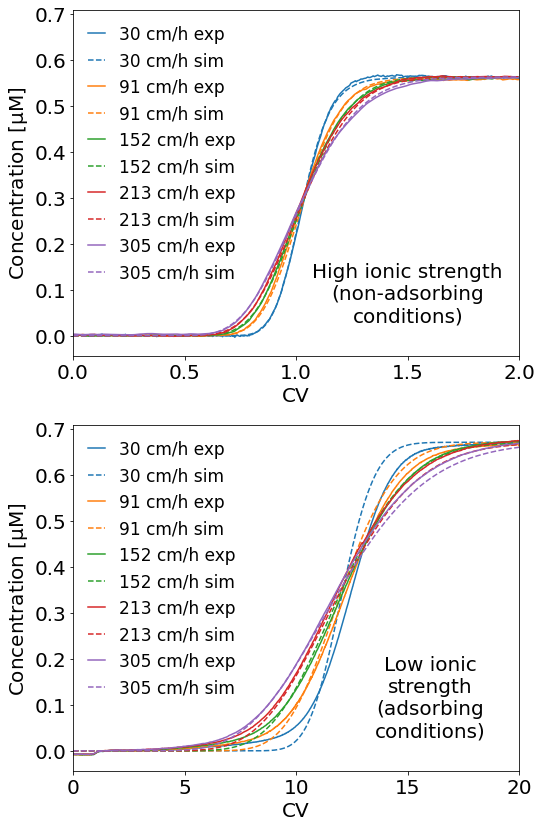

In [99]:
fig, ax = plt.subplots(2, 1, sharey=True)
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 14, forward=True)
for i in range(2):
    ax[i].set_xlabel('CV')
    ax[i].set_ylabel(r'Concentration [$\rm{\mu}$M]')

for v in velocity_list:
    for i, f in enumerate(files_save):
        if v == my_data_save[f].velocity:    
            df = my_data_save[f].df
            label = f'{int(my_data_save[f].velocity)} cm/h'
            ax[0].plot(df.UV1_215nm_cv, df.c_215nm_mM*1e3, label=label+' exp')

            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            t      = simulation.root.output.solution.solution_times
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            ax[0].plot(t*my_data_save[f].flow/120, c_out*1e3, linestyle='--', color=ax[0].lines[-1].get_color(), label=label+' sim')

ax[0].legend(loc='best', frameon=False, handlelength=1, fontsize=17)
ax[0].set_xlim(0, 2.0)
label = 'High ionic strength\n(non-adsorbing\nconditions)'
ax[0].text(0.75, .1, label, horizontalalignment='center', transform=ax[0].transAxes)

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            label = f'{int(my_data[f].velocity)} cm/h'
            flow = my_data[f].flow
            ax[1].plot(df.t_215nm_s*flow/(2.0*60.0), df.c_215nm_mM*1e3, label=label + ' exp')
    
            file_name = f[:f.find('.')] + '.h5'
            file_path = './hdf5_simulation_files/' + file_name
            simulation = Cadet()
            simulation.filename = file_path
            simulation.load()
            t      = simulation.root.output.solution.solution_times
            c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
            ax[1].plot(t*flow/(2.0*60.0), c_out*1e3, linestyle='--', color=ax[1].lines[-1].get_color(), label=label + ' sim') 

ax[1].legend(loc='best', frameon=False, handlelength=1, fontsize=17)
ax[1].set_xlim(0, 20)
label = 'Low ionic\nstrength\n(adsorbing\nconditions)'
ax[1].text(0.8, .1, label, horizontalalignment='center', transform=ax[1].transAxes)

fig.patch.set_alpha(1.0)
plt.subplots_adjust(hspace=0.2)

fig.savefig('./images/manuscript_images/stacked_exp_vs_sim.png', dpi=300, bbox_inches='tight')
fig.savefig('./images/manuscript_images/stacked_exp_vs_sim.pdf', bbox_inches='tight')

In [93]:
max_vals = []
for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            max_vals.append(max(df.c_215nm_mM*1e3))
            
            if v > 31:
                file_name = f[:f.find('.')] + '.h5'
                file_path = './hdf5_simulation_files/' + file_name
                simulation = Cadet()
                simulation.filename = file_path
                simulation.load()
                t      = simulation.root.output.solution.solution_times
                c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
                max_vals.append(max(c_out*1e3))
                
max_val = max(max_vals)

In [94]:
d_particle = 9.0e-5 # m

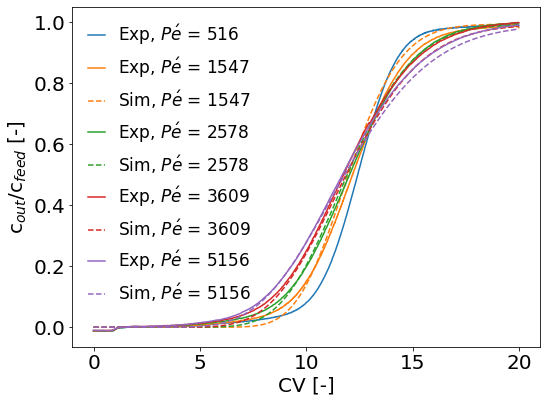

In [95]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for v in velocities:
    for f in files:
        if my_data[f].velocity == v:
            df = data_break[f]
            pe_val = d_particle * my_data[f].velocity / (eps_c * 100 * 3600 * Dp)
            label = fr'$P\'{{e}}$ = {pe_val:.0f}'
            flow = my_data[f].flow
            ax.plot(df.t_215nm_s*flow/(2.0*60.0), df.c_215nm_mM*1e3/max_val, label='Exp, ' + label)
    
            if v > 31:
                file_name = f[:f.find('.')] + '.h5'
                file_path = './hdf5_simulation_files/' + file_name
                simulation = Cadet()
                simulation.filename = file_path
                simulation.load()
                t      = simulation.root.output.solution.solution_times
                c_out  = simulation.root.output.solution.unit_004.solution_outlet_comp_000
                ax.plot(t*flow/(2.0*60.0), c_out*1e3/max_val, linestyle='--', color=plt.gca().lines[-1].get_color(), label='Sim, ' + label) 

ax.legend(loc='best', frameon=False, handlelength=1, fontsize=17)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/breakthrough/global_without_30_reformatted.png', dpi=300)

In [59]:
Dp, eps_c

(4.3e-11, 0.34456262415678807)

### Keq and Ds estimation

**Simultaneous**

In [63]:
def get_combined_residual(params, c_load, Dp, eps_c, eps_p, files, data_break, my_data):
    residuals = []
    for f in files:
        if my_data[f].flow > 0.2:
            df = data_break[f]
            flow = my_data[f].flow
            residual = cadet_utils.get_breakthrough_sim_residual(params, c_load, Dp, 
                                                             eps_c, eps_p, df, flow)
            residuals.append(residual)
    print(np.array(residuals).sum(), params)
    return np.array(residuals).sum()

def get_single_residual(params, f, c_load, Dp, eps_c, eps_p, files, data_break, my_data):
    df = data_break[f]
    flow = my_data[f].flow
    residual = cadet_utils.get_breakthrough_sim_residual(params, c_load, Dp, 
                                                             eps_c, eps_p, df, flow)
    print(np.array(residual).sum(), params)
    return np.array(residual).sum()


In [64]:
bounds = [(105, 115), (0, 0.1*Dp)]
args = (c_load, Dp, eps_c, eps_p, files, data_break, my_data)
fit = optimize.differential_evolution(get_combined_residual,
                                      bounds, args=args, disp=True, popsize=10, 
                                      workers=10)
print(fit)

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


0.003818019492719692 [1.05155361e+02 1.74761657e-12]
0.006131639125516118 [1.14303895e+02 5.85378559e-14]
0.003451708298652842 [1.06015080e+02 2.77755761e-12]
0.0038078187155680945 [1.12145048e+02 9.18836588e-13]
0.0026480968303512873 [1.06817980e+02 2.17800919e-12]
0.0032622370468377484 [1.11210085e+02 1.94528875e-12]
0.004188787670690148 [1.05585283e+02 3.61235787e-12]
0.0028477524988035335 [1.09515021e+02 2.82482936e-12]
0.002432466925795726 [1.08691670e+02 2.41257663e-12]
0.0045758874812167364 [1.11863429e+02 3.69300224e-12]
0.005948057607297754 [1.14522314e+02 1.43318357e-12]
0.003327787790420966 [1.07191696e+02 4.37324094e-13]
0.0034964499232646796 [1.09034892e+02 4.12155103e-12]
0.002973047125155225 [1.08306675e+02 3.30141839e-12]
0.00517926192782861 [1.12553577e+02 3.90911219e-12]
0.00348459519292639 [1.07734495e+02 2.32831448e-13]
0.005726061106255168 [1.13594585e+02 3.15399691e-12]
0.0025191639926907495 [1.10105029e+02 8.37684925e-13]
0.002858595410120504 [1.10832488e+02 1.55

0.0022183347991624486 [1.08098039e+02 1.99352631e-12]
0.0021484336120999726 [1.09255680e+02 1.28190466e-12]
0.0021270984429826653 [1.09178668e+02 1.40045493e-12]
0.0021499878856708495 [1.08111366e+02 1.76112290e-12]
0.0021850597889167974 [1.08061782e+02 1.88442531e-12]
0.00210038456038165 [1.08472874e+02 1.42788216e-12]
0.0021965943016932403 [1.07759381e+02 1.65401077e-12]
0.0022236465346598304 [1.07664252e+02 1.55486952e-12]
0.002143959342453093 [1.08306728e+02 1.29445623e-12]
0.0021011896713887153 [1.08400148e+02 1.53023923e-12]
0.0021079814862287826 [1.08620741e+02 1.66427918e-12]
0.0025172995469558306 [1.07979533e+02 8.27883825e-13]
differential_evolution step 7: f(x)= 0.00209102
0.002093458927759033 [1.0880494e+02 1.4646036e-12]
0.002223202013770459 [1.07717375e+02 1.82098220e-12]
0.0020955912430777007 [1.08603930e+02 1.41329994e-12]
0.0021418072852448476 [1.09224317e+02 1.51999533e-12]
0.002092611654256778 [1.08558405e+02 1.51625924e-12]
0.0022108357829176088 [1.09067259e+02 1.03

0.0020917151190070872 [1.08612876e+02 1.48922990e-12]
0.0035524103923463383 [1.08612876e+02 4.30000000e-12]
0.002090621665629949 [1.08616825e+02 1.49085784e-12]
0.0020924223101149784 [1.08616825e+02 1.49085784e-12]
0.003552945613686289 [1.08616825e+02 4.30000000e-12]
0.0020915713810690053 [1.08620504e+02 1.49237414e-12]
0.0020913035062092777 [1.08620504e+02 1.49237414e-12]
0.0035536229550404684 [1.08620504e+02 4.30000000e-12]
0.0020913445436042018 [1.08620622e+02 1.49242280e-12]
0.002091443284880156 [1.08620622e+02 1.49242280e-12]
0.0035532818191513767 [1.08620622e+02 4.30000000e-12]
0.0020921902642985785 [1.08620708e+02 1.49245834e-12]
0.0020912415146678476 [1.08620708e+02 1.49245834e-12]
0.0035530945640567554 [1.08620708e+02 4.30000000e-12]
0.0020920718594367245 [1.08620723e+02 1.49246432e-12]
0.0020922120902273646 [1.08620723e+02 1.49246432e-12]
0.0035530208904073573 [1.08620723e+02 4.30000000e-12]
0.002090870962041606 [1.08620736e+02 1.49246996e-12]
0.0020906282389715125 [1.0862073

**Individual**

In [114]:
# fits = {}

# for f in files:
#     bounds = [(105, 115), (0, 0.1*Dp)]
#     args = (f, c_load, Dp, eps_c, eps_p, files, data_break, my_data)
#     fit = optimize.differential_evolution(get_single_residual,
#                                           bounds, args=args, disp=True, popsize=10, 
#                                           workers=10)
#     fits[f] = fit
#     print(fit)

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


0.0009294171420705347 [1.13702278e+02 1.04778134e-12]
0.0016793584780731249 [1.07020939e+02 6.03603100e-13]
0.0008978385260239203 [1.14534818e+02 1.70042722e-13]
0.0011278141606913088 [1.09843000e+02 1.41347759e-12]
0.001263864559290193 [1.10991492e+02 4.19652198e-12]
0.0011483484418303642 [1.12325275e+02 3.43271585e-12]
0.0009942198437347465 [1.11280710e+02 1.84018949e-12]
0.002285906599854598 [1.05067326e+02 1.19073743e-12]
0.0015384476085089159 [1.08883404e+02 3.56277279e-12]
0.00114400901036287 [1.13348294e+02 2.82393255e-12]
0.001447489771023225 [1.07959916e+02 7.06685025e-13]
0.0008805547741820165 [1.10120588e+02 3.76204311e-13]
0.0011841299377018566 [1.12626620e+02 3.76471498e-12]
0.0015165497382796126 [1.08205410e+02 1.68526976e-12]
0.001074469589665949 [1.11643775e+02 2.61136505e-12]
0.001240034749457073 [1.14407157e+02 2.42380840e-12]
0.0021547347729749503 [1.05866328e+02 2.09476854e-12]
0.0014584186000684886 [1.09149150e+02 3.20584065e-12]
0.002017830890889485 [1.06407008e+0

0.0009259891667372106 [1.09669651e+02 1.37604958e-13]
0.0006319270345758861 [1.12107736e+02 3.38649730e-13]
0.0006717542792526454 [1.12281116e+02 4.77296079e-13]
0.000745663291837656 [1.10583989e+02 1.81675949e-13]
0.0011719569041043082 [1.09767227e+02 1.62202733e-12]
0.0005754702551102556 [1.12046022e+02 1.47899694e-13]
0.0006616373403123054 [1.11242158e+02 2.43473421e-13]
0.0012056702713438409 [1.12820951e+02 3.92649192e-12]
0.0006693736489746421 [1.10900787e+02 9.69577433e-14]
0.0011681154098362463 [1.14168663e+02 2.13136334e-12]
0.0010860916084146999 [1.10652772e+02 2.01675332e-12]
0.0010201772444699377 [1.11620798e+02 2.17446361e-12]
differential_evolution step 7: f(x)= 0.000566566
0.0006781162059162138 [1.11691916e+02 4.49532734e-13]
0.0006777181412070715 [1.11674879e+02 4.44181211e-13]
0.0007179382035352076 [1.13512957e+02 2.40866730e-13]
0.0005715300117217574 [1.12368919e+02 1.29538844e-13]
0.0006014465830123628 [1.12254164e+02 2.35159703e-13]
0.0005990697707340717 [1.12228965e

0.0010970689853842391 [1.11856026e+02 2.88236042e-12]
0.0005433190881914357 [1.12285000e+02 4.52298376e-14]
0.0007368174993486544 [1.12033988e+02 7.23743337e-13]
0.001084993530721336 [1.12441540e+02 2.78246188e-12]
0.0011194089956082865 [1.11561702e+02 2.98537088e-12]
0.0011309197856612316 [1.12049943e+02 3.24652091e-12]
differential_evolution step 14: f(x)= 0.000528919
0.000544138465418068 [1.12343735e+02 4.36727422e-14]
0.0007516900892603171 [1.12445795e+02 7.71129836e-13]
0.0005329633528584169 [1.12038920e+02 1.11986135e-14]
0.0005360888767324076 [1.12250492e+02 2.39539769e-14]
0.0005503736931638747 [1.12004205e+02 6.42062294e-14]
0.0005486009860429492 [1.11704306e+02 1.18730989e-14]
0.0005451862982601753 [1.11870292e+02 3.23359087e-14]
0.0005366534954604541 [1.12354668e+02 1.87846691e-14]
0.0006468908792708678 [1.12340046e+02 3.84948351e-13]
0.0005443471245475384 [1.12601922e+02 5.64219371e-15]
0.0005486009860429492 [1.11704306e+02 1.18730989e-14]
0.0005589703341473501 [1.11878536e

0.0012196771296234372 [1.11928108e+02 4.30000000e-12]
0.0005285417634727962 [1.12122284e+02 9.59038598e-16]
0.0005285469380253211 [1.12122284e+02 9.59038598e-16]
0.0012174012414357218 [1.12122284e+02 4.30000000e-12]
0.0005284223198748732 [1.12189593e+02 9.79335646e-16]
0.0005284223373930398 [1.12189593e+02 9.79335646e-16]
0.00121735831972606 [1.12189593e+02 4.30000000e-12]
0.0005285095153537265 [1.12209551e+02 9.85354112e-16]
0.0005285179610811335 [1.12209551e+02 9.85354112e-16]
0.0012173431280516074 [1.12209551e+02 4.30000000e-12]
0.0005285365866252351 [1.12216588e+02 9.87476133e-16]
0.0005285627093830396 [1.12216588e+02 9.87476133e-16]
0.0012174568503220413 [1.12216588e+02 4.30000000e-12]
0.0005285533358613208 [1.12218836e+02 9.88153852e-16]
0.0005285617402150742 [1.12218836e+02 9.88153852e-16]
0.0012171308660469116 [1.12218836e+02 4.30000000e-12]
0.0005285835134722375 [1.12219308e+02 9.88296227e-16]
0.0005285834557390325 [1.12219308e+02 9.88296227e-16]
0.0012174937743729367 [1.12219

0.0007568336787266151 [1.10369564e+02 2.15317608e-13]
0.0005600997680071676 [1.11014566e+02 1.28024670e-12]
0.0003639991362652678 [1.09513147e+02 1.75420173e-12]
0.0006183197966088038 [1.07917786e+02 5.52106657e-13]
0.0006013642608661104 [1.11209110e+02 1.44472354e-12]
0.0004586788822042517 [1.10259509e+02 1.86999507e-12]
differential_evolution step 4: f(x)= 0.000350561
0.00033304495683692106 [1.09053892e+02 1.39850283e-12]
0.00038607510307411374 [1.08705044e+02 1.04178228e-12]
0.0003582294459945148 [1.08934914e+02 1.11624459e-12]
0.00044667258440562053 [1.10360396e+02 1.58887887e-12]
0.00033471626877824807 [1.09296696e+02 1.27624620e-12]
0.0005539256597708265 [1.10904119e+02 1.69662059e-12]
0.0005853207799928918 [1.10995700e+02 1.84147288e-12]
0.0003982050159094446 [1.10061694e+02 1.21693465e-12]
0.00033863156292632653 [1.09301837e+02 1.58065379e-12]
0.00042454700653824374 [1.09949803e+02 9.42758068e-13]
0.0003709291042478298 [1.09600782e+02 1.76604951e-12]
0.00042173812016794754 [1.0

0.0003305462319440202 [1.09250618e+02 1.41013725e-12]
0.0007764742282344836 [1.09250618e+02 4.30000000e-12]
0.0003301352735546595 [1.09250436e+02 1.41019550e-12]
0.00033011304124754584 [1.09250436e+02 1.41019550e-12]
0.0007763817080087837 [1.09250436e+02 4.30000000e-12]
0.0008575279910561416 [109.25044206   0.        ]
0.0008575280012907915 [109.25044207   0.        ]
0.0007764895817658658 [1.09250442e+02 4.30000000e-12]
0.0003322520145732947 [1.09250436e+02 1.32457722e-12]
0.00033172169698012985 [1.09250436e+02 1.32457722e-12]
0.000776568630113979 [1.09250436e+02 4.30000000e-12]
0.00033044886513790685 [1.09250436e+02 1.39970162e-12]
0.0003308140894580718 [1.09250436e+02 1.39970162e-12]
0.000776430692763024 [1.09250436e+02 4.30000000e-12]
0.00033114418074378405 [1.09250436e+02 1.40762317e-12]
0.000331036538786026 [1.09250436e+02 1.40762317e-12]
0.000776126084302845 [1.09250436e+02 4.30000000e-12]
0.0003307892932875771 [1.09250436e+02 1.41006514e-12]
0.00033064879355835305 [1.09250436e+

0.00033076701643893755 [1.09250436e+02 1.41019550e-12]
0.000330618214601941 [1.09250436e+02 1.41019550e-12]
0.0007763696974107894 [1.09250436e+02 4.30000000e-12]
0.0003309253546023541 [1.09250436e+02 1.41019550e-12]
0.00033037850859408204 [1.09250436e+02 1.41019550e-12]
0.0007763817080087837 [1.09250436e+02 4.30000000e-12]
     fun: 0.0003305377961492607
 message: 'Optimization terminated successfully.'
    nfev: 397
     nit: 10
 success: True
       x: array([1.09250428e+02, 1.41019800e-12])
0.0012573955189357393 [1.08301547e+02 3.52913173e-12]
0.0018287184902451093 [1.0520045e+02 1.8669283e-12]
0.0010978062995499389 [1.10140029e+02 3.71859551e-12]
0.0009719907927131762 [1.12199881e+02 2.04826634e-12]
0.0014832357838324537 [1.13774993e+02 2.89826810e-12]
0.0008460127113548983 [1.08624785e+02 1.59402132e-12]
0.0013472247616159387 [1.07319726e+02 2.70909224e-12]
0.0016328740518011203 [1.06820899e+02 4.01999322e-12]
0.0005205088941008981 [1.11405593e+02 7.20906383e-13]
0.000938430759894

0.0004912245243894547 [1.09431829e+02 5.46306053e-13]
differential_evolution step 6: f(x)= 0.000386918
0.00038706874723602855 [1.10372156e+02 4.85567891e-13]
0.00039493219880290287 [1.10170452e+02 4.43381042e-13]
0.0004055892777141865 [1.10008160e+02 4.61779905e-13]
0.0004238812555794078 [1.10120422e+02 2.75347662e-13]
0.0004050282550987523 [1.1000922e+02 5.2885866e-13]
0.0003899040273805717 [1.10450131e+02 4.34766959e-13]
0.00039005529613978174 [1.10545795e+02 5.00049609e-13]
0.00040393920962702247 [1.10076595e+02 4.07950659e-13]
0.00040626426658599946 [1.10767054e+02 5.43968160e-13]
0.00040729258935057194 [1.09987229e+02 5.09250232e-13]
0.00038679482647447516 [1.10407824e+02 5.22286426e-13]
0.00038862895010328784 [1.10295173e+02 5.12050170e-13]
0.0004282573877583585 [1.10873826e+02 3.42488071e-13]
0.00040629553758785817 [1.099910e+02 5.173685e-13]
0.000396970647730355 [1.10522567e+02 6.37842173e-13]
0.0003873608786996971 [1.10435111e+02 5.04778324e-13]
0.0003896923127148592 [1.105364

0.0015070154264885912 [1.07512406e+02 4.30000000e-12]
0.00043753717253647225 [1.09743674e+02 4.58136306e-13]
0.0004383176444004627 [1.09743674e+02 4.58136306e-13]
0.0011972610799810953 [1.09743674e+02 4.30000000e-12]
0.0003872453411245205 [1.10355410e+02 5.17216798e-13]
0.0003873525290551197 [1.10355410e+02 5.17216798e-13]
0.0011835827141289748 [1.1035541e+02 4.3000000e-12]
0.0003872680436332799 [1.10395268e+02 5.21066270e-13]
0.0003864638860016957 [1.10395268e+02 5.21066270e-13]
0.0011841373019798821 [1.10395268e+02 4.30000000e-12]
0.0003866774643805119 [1.10400721e+02 5.21592855e-13]
0.00038708176394900237 [1.10400721e+02 5.21592855e-13]
0.001183286899826355 [1.10400721e+02 4.30000000e-12]
0.00038688000507742056 [1.10406943e+02 5.22193775e-13]
0.0003875750588429688 [1.10406943e+02 5.22193775e-13]
0.001183989805158833 [1.10406943e+02 4.30000000e-12]
0.00038671624285988 [1.10407772e+02 5.22273815e-13]
0.00038688763991549563 [1.10407772e+02 5.22273815e-13]
0.0011840169857456598 [1.10407

0.00029426697987175254 [1.07896849e+02 1.79225810e-12]
0.0004757951853149437 [1.05176862e+02 3.09626214e-12]
0.0006801108206909094 [1.06781111e+02 6.23877224e-13]
0.000552387584230274 [1.05276151e+02 3.69479753e-12]
0.0004735170257135783 [1.06281734e+02 3.66324322e-12]
0.0012212979731429689 [1.12312318e+02 3.90009977e-12]
0.00026632469021119486 [1.05996485e+02 2.17541407e-12]
0.0006595339935960777 [1.09631185e+02 1.09674096e-12]
0.000548296087566533 [1.07932955e+02 9.14572363e-13]
0.0005392194245095462 [1.08920067e+02 2.99260333e-12]
0.0002828138071339351 [1.06136722e+02 2.53084193e-12]
0.00021038025892233938 [1.06576143e+02 2.08116994e-12]
0.0004749362441276692 [1.09094842e+02 1.83590040e-12]
0.0006185151210718154 [1.06623740e+02 7.39053841e-13]
0.000519112293748194 [1.05593177e+02 3.67719898e-12]
0.00031669407997189576 [1.06177701e+02 1.53583568e-12]
0.0004571015470829769 [1.05248547e+02 1.41222879e-12]
differential_evolution step 2: f(x)= 0.000203184
0.00029824469749370025 [1.079799

0.00023968584102904196 [1.06922816e+02 2.46976108e-12]
0.00020441353430795508 [1.06948133e+02 2.13146400e-12]
0.00020311401613912715 [1.06803269e+02 2.04157670e-12]
0.0002532578008968334 [1.06821767e+02 1.64914528e-12]
0.00020563995505227275 [1.06747161e+02 2.13691882e-12]
0.00020473166775165154 [1.06778238e+02 1.99889211e-12]
0.000206956598532489 [1.06669931e+02 2.02635129e-12]
0.00020544711247166562 [1.06690454e+02 2.04902386e-12]
0.00020433310105289894 [1.06738823e+02 2.09823161e-12]
0.0002036933218401178 [1.06813560e+02 2.00531515e-12]
0.00020238935788315492 [1.06878963e+02 2.07328952e-12]
0.00020415187677689465 [1.06783738e+02 2.11217156e-12]
differential_evolution step 9: f(x)= 0.000202115
0.0002021152836484519 [1.06844241e+02 2.06833359e-12]
0.00020243965110502846 [1.06844241e+02 2.06833359e-12]
0.000576830580326485 [1.06844241e+02 4.30000000e-12]
0.0011821518990337225 [105.   0.]
0.0011825040813576604 [105.00000001   0.        ]
0.0006682767152202974 [1.05e+02 4.30e-12]
0.00026

0.0009235905340631599 [1.10622243e+02 2.77112366e-12]
0.0003625440627027684 [1.07626558e+02 2.36186176e-12]
0.0003677370648166926 [1.06936827e+02 1.15792961e-12]
0.0006270411601513162 [1.08551018e+02 3.37428101e-12]
0.0008925252608925302 [1.10291367e+02 3.11348488e-12]
0.0002893899876612661 [1.06556025e+02 1.68525713e-12]
0.0005391937075178739 [1.08855420e+02 1.20486531e-12]
0.000618001809120218 [1.09416064e+02 1.39844624e-12]
0.0006104257128819976 [1.08823438e+02 2.95871459e-12]
differential_evolution step 3: f(x)= 0.000277758
0.0003047980284250698 [1.06362416e+02 1.92144070e-12]
0.00033084815591079156 [1.06991668e+02 2.39557639e-12]
0.0002859504066548741 [1.06762363e+02 1.58901762e-12]
0.0005607194651971581 [1.06898466e+02 6.69536812e-13]
0.0004093332232618875 [1.07370383e+02 2.78196683e-12]
0.0003854613772692791 [1.07228484e+02 1.11121010e-12]
0.000529747854689019 [1.07753714e+02 7.85881731e-13]
0.0004529510005105485 [1.08581587e+02 1.68866116e-12]
0.0004877033216341253 [1.08581587e

0.0002781516426023636 [1.06805204e+02 1.67913676e-12]
0.0002819862395362686 [1.06883595e+02 1.60248345e-12]
0.0002834289739460819 [1.06898231e+02 2.01637181e-12]
0.0002944383125875449 [1.07387226e+02 1.91719910e-12]
differential_evolution step 10: f(x)= 0.000273551
0.0002741685406148816 [1.06949253e+02 1.73808908e-12]
0.0002814364309040303 [1.07095509e+02 1.62524466e-12]
0.0002853386106076523 [1.06627507e+02 1.92232857e-12]
0.0002782176429584509 [1.06730823e+02 1.85153903e-12]
0.0002813014698412032 [1.06917632e+02 1.98922222e-12]
0.0002745308355257006 [1.06842798e+02 1.80746020e-12]
0.00027580195058944033 [1.06945768e+02 1.89438095e-12]
0.00027894692055761367 [1.07138000e+02 1.68950912e-12]
0.0002846205532576241 [1.07262866e+02 1.88389439e-12]
0.00027411983234272894 [1.06886610e+02 1.75727362e-12]
0.00027580976132992766 [1.06827955e+02 1.72255664e-12]
0.00027743599736936746 [1.06952910e+02 1.65862581e-12]
0.0002739787855445488 [1.06924812e+02 1.83554457e-12]
0.0002741305210059022 [1.06

In [117]:
for f in files:
    flow = my_data[f].flow
    print(f, '\n', flow, fits[f].x, '\n'*2)

CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2004.xls 
 0.1 [1.12219509e+02 9.88359302e-16] 


CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2003.xls 
 0.5 [1.09250428e+02 1.41019800e-12] 


CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2001.xls 
 0.3 [1.10407824e+02 5.22286426e-13] 


CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2002.xls 
 1 [1.06844241e+02 2.06833359e-12] 


CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2005.xls 
 0.7 [1.06949253e+02 1.77995892e-12] 




In [145]:
keq_vals = []
ds_vals  = []
flows    = []

for f in files:
    keq_vals.append(fits[f].x[0])
    ds_vals.append(fits[f].x[1])
    flows.append(my_data[f].flow)
    
    
print(np.array(keq_vals).mean(), np.array(ds_vals).mean())

109.13425100850195 1.1563530583011522e-12


In [146]:
mat = []
for f, keq, ds in zip(flows, keq_vals, ds_vals):
    mat.append([f, keq, ds])
    
mat = np.array(mat)
mat = mat[np.argsort(mat[:, 0])]
mat

array([[1.00000000e-01, 1.12219509e+02, 9.88359302e-16],
       [3.00000000e-01, 1.10407824e+02, 5.22286426e-13],
       [5.00000000e-01, 1.09250428e+02, 1.41019800e-12],
       [7.00000000e-01, 1.06949253e+02, 1.77995892e-12],
       [1.00000000e+00, 1.06844241e+02, 2.06833359e-12]])

In [229]:
# min(keq_vals), max(keq_vals)
min(ds_vals), max(ds_vals)

(9.88359301842116e-16, 2.0683335925666254e-12)

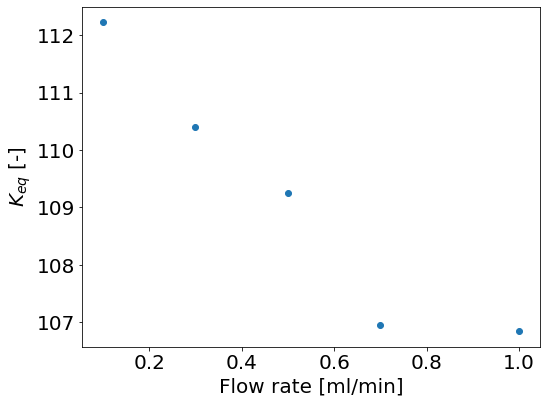

In [150]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Flow rate [ml/min]')
ax.set_ylabel(r'$K_{eq}$ [-]')

ax.scatter(flows, keq_vals)

fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/breakthrough/individual_keq_v_flow_rate.png', dpi=300)

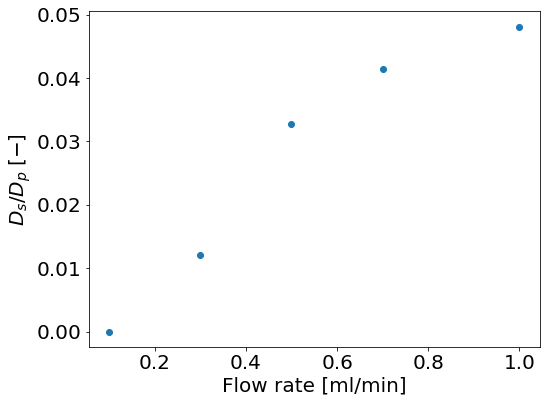

In [151]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Flow rate [ml/min]')
ax.set_ylabel('$D_s/D_p \; [-]$')

ax.scatter(flows, np.array(ds_vals)/Dp)

fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/breakthrough/individual_ds_v_flow_rate.png', dpi=300)

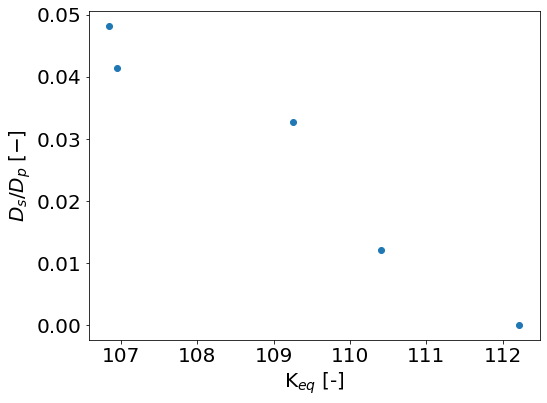

In [156]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel(r'K$_{eq}$ [-]')
ax.set_ylabel('$D_s/D_p \; [-]$')

ax.scatter(keq_vals, np.array(ds_vals)/Dp)

fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/breakthrough/individual_ds_v_keq.png', dpi=300)

In [125]:
# f = 'CH 2021 04 04 lysozyme dilute breakthrough 20 B rep 2001.xls'
# df   = data_break[f]
# flow = my_data[f].flow

# flow = my_data[f].flow
# Dax  = cadet_utils.get_Dax(flow)

# guess = [106, 0.05*Dp]

# #     bounds = [(105, 0), (112, Dp*0.1)]
# bounds = [(105, 115), (0, Dp*0.1)]
# args   = (c_load, Dp, eps_c, eps_p, df, flow)    

# fit = optimize.minimize(cadet_utils.get_breakthrough_sim_residual, guess, args=args)

In [109]:
# fits = {}

# for f in files:
#     df   = data_break[f]
#     flow = my_data[f].flow
    
#     flow = my_data[f].flow
#     Dax  = cadet_utils.get_Dax(flow)
    
#     guess = [106, 0.05*Dp]
    
# #     bounds = [(105, 0), (112, Dp*0.1)]
#     bounds = [(105, 115), (0, Dp*0.1)]
#     args   = (c_load, Dp, eps_c, eps_p, df, flow)    
    
#     fit = optimize.minimize(cadet_utils.get_breakthrough_sim_residual, guess, 
#                                  bounds=bounds, args=args)
#     fits[f] = fit
#     print(my_data[f].flow, fits[f].x)